# Exercise
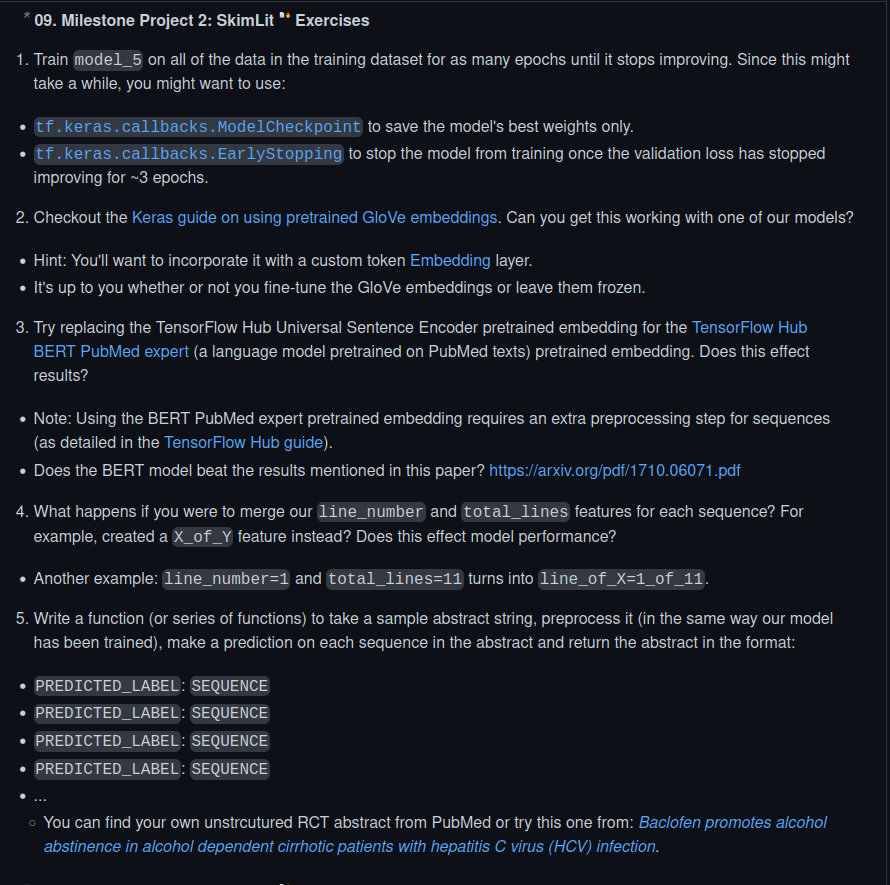


# Extra Resources


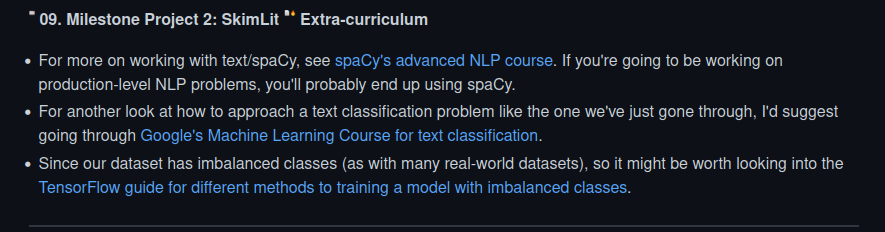

## Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py

--2022-09-04 04:10:43--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22463 (22K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  21.94K  --.-KB/s    in 0s      

2022-09-04 04:10:44 (141 MB/s) - ‘helper_functions.py’ saved [22463/22463]



In [4]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix, calculate_results, get_lines, preprocess_text_with_line_numbers

In [5]:
from helper_functions import model_check_point_callback, create_early_stopping_callback, create_tensorboard_callback, reduce_learning_rate_callback

## Inputs

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import random
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding

from tensorflow.keras import mixed_precision

In [7]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5a1f2fa6-2763-d2be-5904-65f9406f56d7)


## Setting up Mixed Precision Training

In [8]:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [9]:
# mixed_precision.global_policy()

## Getting the data

In [10]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [11]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [12]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [13]:
os.listdir(data_dir)

['dev.txt', 'train.txt', 'test.txt']

In [14]:
train_lines= get_lines(filenames[1])
len(train_lines), train_lines[:5]

(210040,
 ['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n'])

In [15]:
preprocess_text_with_line_numbers(filenames[1])[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

### Processing the datasets

In [16]:
train_samples= preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples= preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples= preprocess_text_with_line_numbers(data_dir + "test.txt")

In [17]:
train_samples[:1]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11}]

In [18]:
train_df= pd.DataFrame(train_samples)
val_df= pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

In [19]:
train_df[:11]

target                                               text  line_number  \
0   OBJECTIVE  to investigate the efficacy of @ weeks of dail...            0   
1     METHODS  a total of @ patients with primary knee oa wer...            1   
2     METHODS  outcome measures included pain reduction and i...            2   
3     METHODS  pain was assessed using the visual analog pain...            3   
4     METHODS  secondary outcome measures included the wester...            4   
5     METHODS  serum levels of interleukin @ ( il-@ ) , il-@ ...            5   
6     RESULTS  there was a clinically relevant reduction in t...            6   
7     RESULTS  the mean difference between treatment arms ( @...            7   
8     RESULTS  further , there was a clinically relevant redu...            8   
9     RESULTS  these differences remained significant at @ we...            9   
10    RESULTS  the outcome measures in rheumatology clinical ...           10   

    total_lines  
0            11  
1            11  
2            11  
3            11  
4            11  
5            11  
6            11  
7            11  
8            11  
9            11  
10           11

In [20]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()
test_sentences= test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### One Hot Encoder labels

In [22]:
one_hot_encoder= OneHotEncoder(sparse=False)

train_labels_one_hot= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot= one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot= one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot[:5], train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), (180040, 5))

### Label encode `The target labels` 

> Extract labels `target columns` and encode them into integers. Encoding the `string/text` into `numbers`

In [23]:
label_encoder= LabelEncoder()

train_labels_encoder= label_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_encoder= label_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_encoder= label_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_encoder, train_labels_encoder.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

### Class names and number of classes

In [24]:
num_classes= len(label_encoder.classes_)
class_names= label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [25]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
output_sequence_length= int(np.percentile(sent_lens, 95))
output_sequence_length

55

### Text Vectorizer

In [26]:
max_vocab_length= 68000 # Taken from `Table 2` of the paper
max_length= output_sequence_length

text_vectorizer= TextVectorization(
    max_tokens= max_vocab_length,
    output_sequence_length= max_length
)

text_vectorizer.adapt(train_sentences)

In [27]:
sample_text="I am currently learning doing the exercise of NLP or Natural Language Processing which is a part of Machine Learning."
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  389,  2651,  1325,   953, 10386,     2,   177,     4,     1,
           16,  2266,  2111,  2573,   126,    20,     8,   732,     4,
         9386,   953,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [28]:
len(text_vectorizer.get_vocabulary())

64841

In [29]:
rct_20K_vocab_length= len(text_vectorizer.get_vocabulary())
rct_20K_vocab_length

64841

In [30]:
max_vocab_length

68000

In [31]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Embedding Layer

In [32]:
embedding= layers.Embedding(input_dim= rct_20K_vocab_length, output_dim= 128, mask_zero= True, name= "token_embedding")

#### Embedding Example

In [33]:
# Show example embedding
print(f"Sentence before vectorization:\n{sample_text}\n")
vectorized_sentence = text_vectorizer([sample_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
I am currently learning doing the exercise of NLP or Natural Language Processing which is a part of Machine Learning.

Sentence after vectorization (before embedding):
[[  389  2651  1325   953 10386     2   177     4     1    16  2266  2111
   2573   126    20     8   732     4  9386   953     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00109895  0.00504636 -0.03959839 ... -0.04355871 -0.02884733
    0.02339155]
  [-0.02631679 -0.04758621  0.01598159 ...  0.04598746 -0.03906382
   -0.03831134]
  [ 0.01513362 -0.02165678 -0.04386723 ...  0.04749655  0.03611077
   -0.03303707]
  ...
  [-0.02426317  0.03409408 -0.03075795 ... -0.00096887  0.00426267
   -0.0183272 ]
  [-0.02426317  0.03409408 -0.03075795 ... -0.00096887  0.00426267
   -0.0183272 ]
  [-0.02426

## `1` Training the token_character_positional_features_tribrid_embeddings 
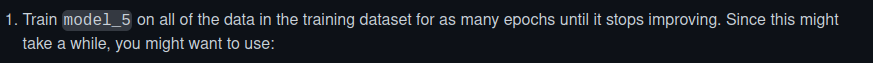

In [34]:
model_url='https://tfhub.dev/google/universal-sentence-encoder/4'

In [35]:
universal_sentence_encoder= hub.KerasLayer(model_url, trainable= False, input_shape=[], dtype="string", name="transfer_learning_USE")

### Character Datasets

In [36]:
def split_sentences(text):
  """
    Function to split text/sentences into characters

  """

  return " ".join(list(text))

In [37]:
train_characters= [split_sentences(sent) for sent in train_sentences]
val_characters= [split_sentences(sent) for sent in val_sentences]
test_characters= [split_sentences(sent) for sent in test_sentences]
train_characters[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [38]:
import string
alphabet= string.ascii_lowercase + string.digits + string.punctuation
len(alphabet), alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [39]:
char_lens= [len(sentence) for sentence in train_sentences]
np.percentile(char_lens, 95)

290.0

#### Custom Character level Token Vectorizer

In [40]:
NUM_CHAR_TOKENS= len(alphabet) + 2
output_seq_char_len= int(np.percentile(char_lens, 95))
character_vectorizer= TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length= output_seq_char_len, name='character_vectorizer')

character_vectorizer.adapt(train_characters)

In [41]:
random_train_chars = random.choice(train_characters)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = character_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
r e g a r d l e s s   t o   t h e   e d u c a t i o n   i n t e r v e n t i o n   a n   i m p r o v e m e n t   o f   t h e   d i s e a s e   s t a t u s   o c c u r s   d u r i n g   c a r d i a c   r e h a b i l i t a t i o n   .

Length of chars: 101

Vectorized chars:
[[ 8  2 18  5  8 10 12  2  9  9  3  7  3 13  2  2 10 16 11  5  3  4  7  6
   4  6  3  2  8 21  2  6  3  4  7  6  5  6  4 15 14  8  7 21  2 15  2  6
   3  7 17  3 13  2 10  4  9  2  5  9  2  9  3  5  3 16  9  7 11 11 16  8
   9 10 16  8  4  6 18 11  5  8 10  4  5 11  8  2 13  5 22  4 12  4  3  5
   3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Character Embeddings

In [42]:
character_embedding= layers.Embedding(input_dim= len(character_vectorizer.get_vocabulary()), output_dim=25, mask_zero=True, name="character_embeddings")

In [43]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = character_embedding(character_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
r e g a r d l e s s   t o   t h e   e d u c a t i o n   i n t e r v e n t i o n   a n   i m p r o v e m e n t   o f   t h e   d i s e a s e   s t a t u s   o c c u r s   d u r i n g   c a r d i a c   r e h a b i l i t a t i o n   .

Embedded chars (after vectorization and embedding):
[[[ 0.02721507 -0.0249025  -0.01796753 ...  0.02415797  0.01526791
    0.02554692]
  [-0.00972421  0.01710261 -0.02483775 ...  0.00917178 -0.01395605
   -0.02503263]
  [-0.01659961  0.01729811  0.01903493 ... -0.03106412  0.04394461
    0.02620027]
  ...
  [-0.04462786 -0.03937185  0.03953246 ...  0.00562469  0.0060047
    0.01641018]
  [-0.04462786 -0.03937185  0.03953246 ...  0.00562469  0.0060047
    0.01641018]
  [-0.04462786 -0.03937185  0.03953246 ...  0.00562469  0.0060047
    0.01641018]]]

Character embedding shape: (1, 290, 25)


### Line Number

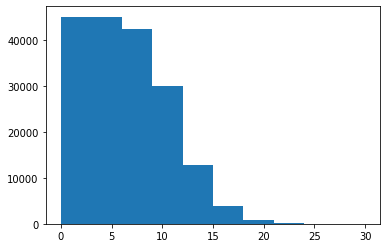

In [44]:
plt.hist(train_df['line_number']);

In [45]:
np.percentile(train_df['line_number'], 98)

15.0

### Line Number dataset

In [46]:
train_df_line_numbers= train_df["line_number"].to_numpy()
val_df_line_numbers= val_df["line_number"].to_numpy()
test_df_line_numbers= test_df["line_number"].to_numpy()

train_df_line_numbers, train_df_line_numbers.shape

(array([ 0,  1,  2, ...,  9, 10, 11]), (180040,))

In [47]:
train_df_line_numbers.dtype

dtype('int64')

### One Hot Encoded Line Number dataset

In [48]:
train_line_numbers_one_hot= tf.one_hot(train_df_line_numbers, depth=15)
val_line_numbers_one_hot= tf.one_hot(val_df_line_numbers, depth=15)
test_line_numbers_one_hot= tf.one_hot(test_df_line_numbers, depth=15)

train_line_numbers_one_hot, train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

### Total Lines

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <a list of 10 Patch objects>)

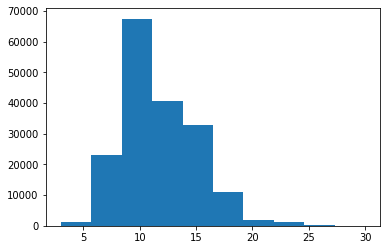

In [49]:
plt.hist(train_df['total_lines'])

In [50]:
np.percentile(train_df['total_lines'], 98)

20.0

### Total Lines dataset

In [51]:
train_df_total_lines= train_df["total_lines"].to_numpy()
val_df_total_lines= val_df["total_lines"].to_numpy()
test_df_total_lines= test_df["total_lines"].to_numpy()

train_df_total_lines, train_df_total_lines.shape

(array([11, 11, 11, ..., 11, 11, 11]), (180040,))

### One Hot Encoded Total Lines dataset

In [52]:
train_total_lines_one_hot= tf.one_hot(train_df_total_lines, depth=20)
val_total_lines_one_hot= tf.one_hot(val_df_total_lines, depth=20)
test_total_lines_one_hot= tf.one_hot(test_df_total_lines, depth=20)

train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

## Building the `Tribrid Embedding model with the whole training dataset`

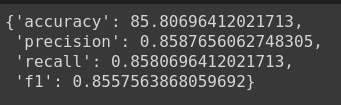

### `1` Token Inputs

In [ ]:
token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

### `2` Character Inputs

In [ ]:
character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

### `3` Line Number Model

In [ ]:
line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

### `4` Total Lines Model

In [ ]:
total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

### `5` Combine Token and character Embeddings

In [ ]:
combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

### `6` Combine the positional embeddings with the `combine_embeddings` above i.e with `token and character embeddings`

In [ ]:
tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings")([line_number_model.output, total_lines_model.output, x])

### `7` Output layer for `Tribrid` model

In [ ]:
output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

### `8` Putting the model together

In [ ]:
tribrid_model_whole= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_model_5")

In [ ]:
tribrid_model_whole.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE (KerasLa  (None, 512)         256797824   ['token_i

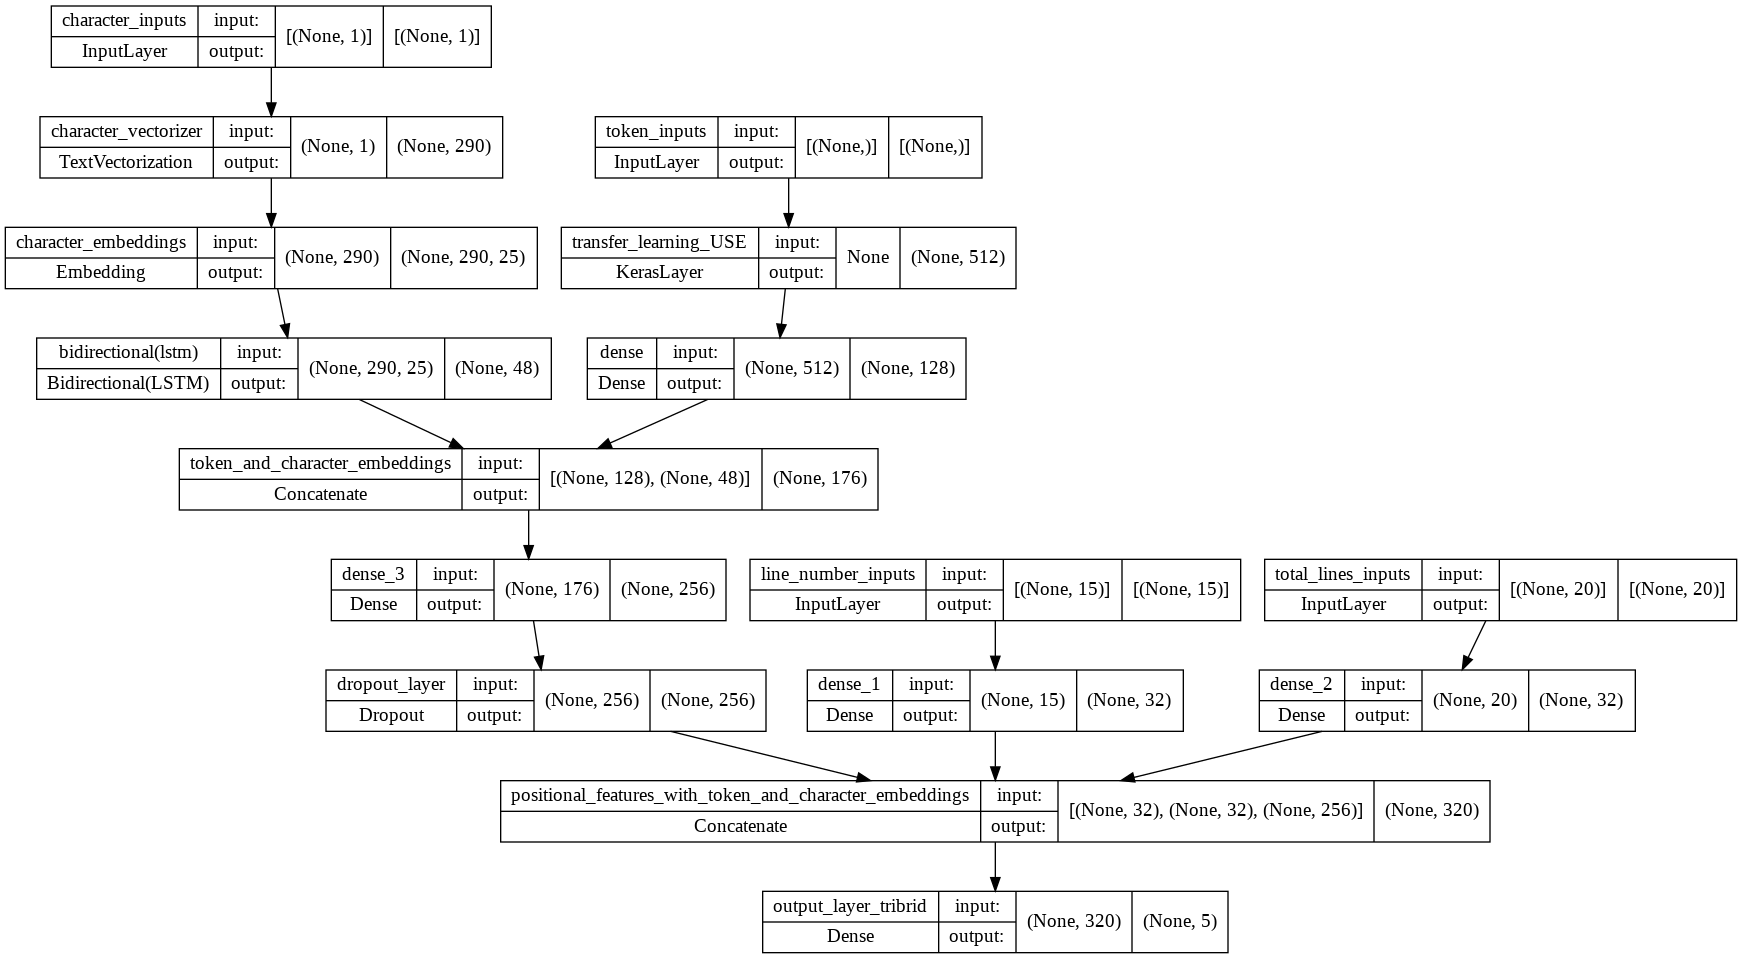

In [ ]:
plot_model(tribrid_model_whole, show_shapes=True)

In [ ]:
tribrid_model_whole.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

### Making datasets performant and load faster

In [ ]:
train_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_characters)) # Data
train_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Labels
train_line_total_token_char_dataset= tf.data.Dataset.zip((train_line_total_token_char_data, train_line_total_token_char_labels)) # Combining data and labels

train_line_total_token_char_dataset= train_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_characters))
val_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot) 
val_line_total_token_char_dataset= tf.data.Dataset.zip((val_line_total_token_char_data, val_line_total_token_char_labels)) 

val_line_total_token_char_dataset= val_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_characters))
test_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_line_total_token_char_dataset= tf.data.Dataset.zip((test_line_total_token_char_data, test_line_total_token_char_labels)) 

test_line_total_token_char_dataset= test_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



train_line_total_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Creating some useful callbacks For Feature Extractor Model

In [ ]:
model_checkpoint_path= 'checkpoints'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset/20220901-112505


### Training the model with `trainable=False` in the pre-trained USE feature extractor model

In [ ]:
# history_tribrid_model_whole= tribrid_model_whole.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.8204
Epoch 1: val_accuracy improved from -inf to 0.84837, saving model to checkpoints
5627/5627 [==============================] - 294s 50ms/step - loss: 0.9567 - accuracy: 0.8204 - val_loss: 0.9090 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9096 - accuracy: 0.8532
Epoch 2: val_accuracy improved from 0.84837 to 0.85284, saving model to checkpoints
5627/5627 [==============================] - 276s 49ms/step - loss: 0.9096 - accuracy: 0.8532 - val_loss: 0.8997 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.8626
Epoch 3: val_accuracy did not improve from 0.85284
5627/5627 [==============================] - 272s 48ms/step - loss: 0.8971 - accuracy: 0.8626 - val_loss: 0.9011 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/10
5627/5627 [=====================

## Evaluating the model

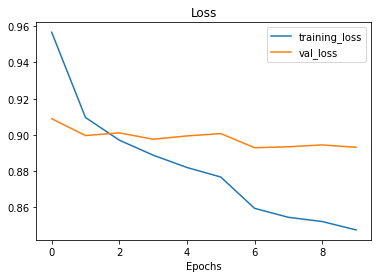

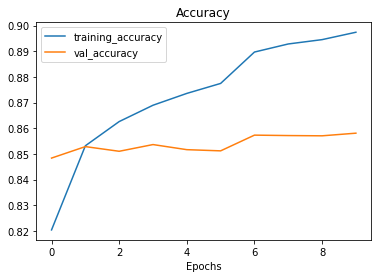

In [ ]:
# plot_loss_curves(history_tribrid_model_whole)

In [ ]:
# tribrid_model_whole_evaluate=tribrid_model_whole.evaluate(val_line_total_token_char_dataset)
# tribrid_model_whole_evaluate

945/945 [==============================] - 22s 23ms/step - loss: 0.8932 - accuracy: 0.8581


[0.8931522369384766, 0.858069658279419]

In [ ]:
# tribrid_model_whole_pred_probs= tribrid_model_whole.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_pred_probs

array([[0.681933  , 0.08759124, 0.01794036, 0.18799558, 0.02453988],
       [0.6070949 , 0.0957007 , 0.03914917, 0.23690814, 0.0211471 ],
       [0.330632  , 0.05893952, 0.02247716, 0.57041824, 0.01753303],
       ...,
       [0.02849247, 0.07224851, 0.0239806 , 0.03367176, 0.8416066 ],
       [0.02282009, 0.4247516 , 0.15586968, 0.03147404, 0.36508462],
       [0.05792545, 0.89015394, 0.01927612, 0.02038916, 0.01225542]],
      dtype=float32)

In [ ]:
# tribrid_model_whole_preds= tf.argmax(tribrid_model_whole_pred_probs, axis=1)
# tribrid_model_whole_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_results= calculate_results(val_labels_encoder, tribrid_model_whole_preds)
# tribrid_model_whole_results

{'accuracy': 85.80696412021713,
 'precision': 0.8587656062748305,
 'recall': 0.8580696412021713,
 'f1': 0.8557563868059692}

## Conclusion

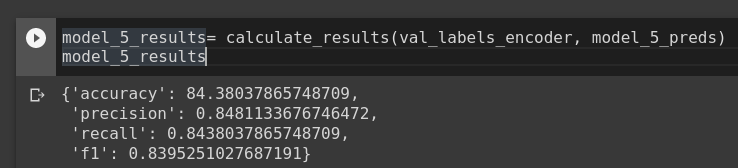

> This is the score the same model got when trained on `10%` of the dataset at every epoch of the model training. The model ran for `5` epochs only.

## Training the model with `trainable=True` as a Fine-Tuned model. The layers of the USE model are unfrozen.

In [ ]:
universal_sentence_encoder_trainable= hub.KerasLayer(model_url, trainable= True, input_shape=[], dtype="string", name="transfer_learning_USE_fine_tuned")

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder_trainable(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_fine_tuning")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_fine_tuned= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_fine_tuned_model")

In [ ]:
tribrid_model_whole_fine_tuned.summary()

Model: "tribrid_embedding_fine_tuned_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE_fine_tun  (None, 512)         256797824   

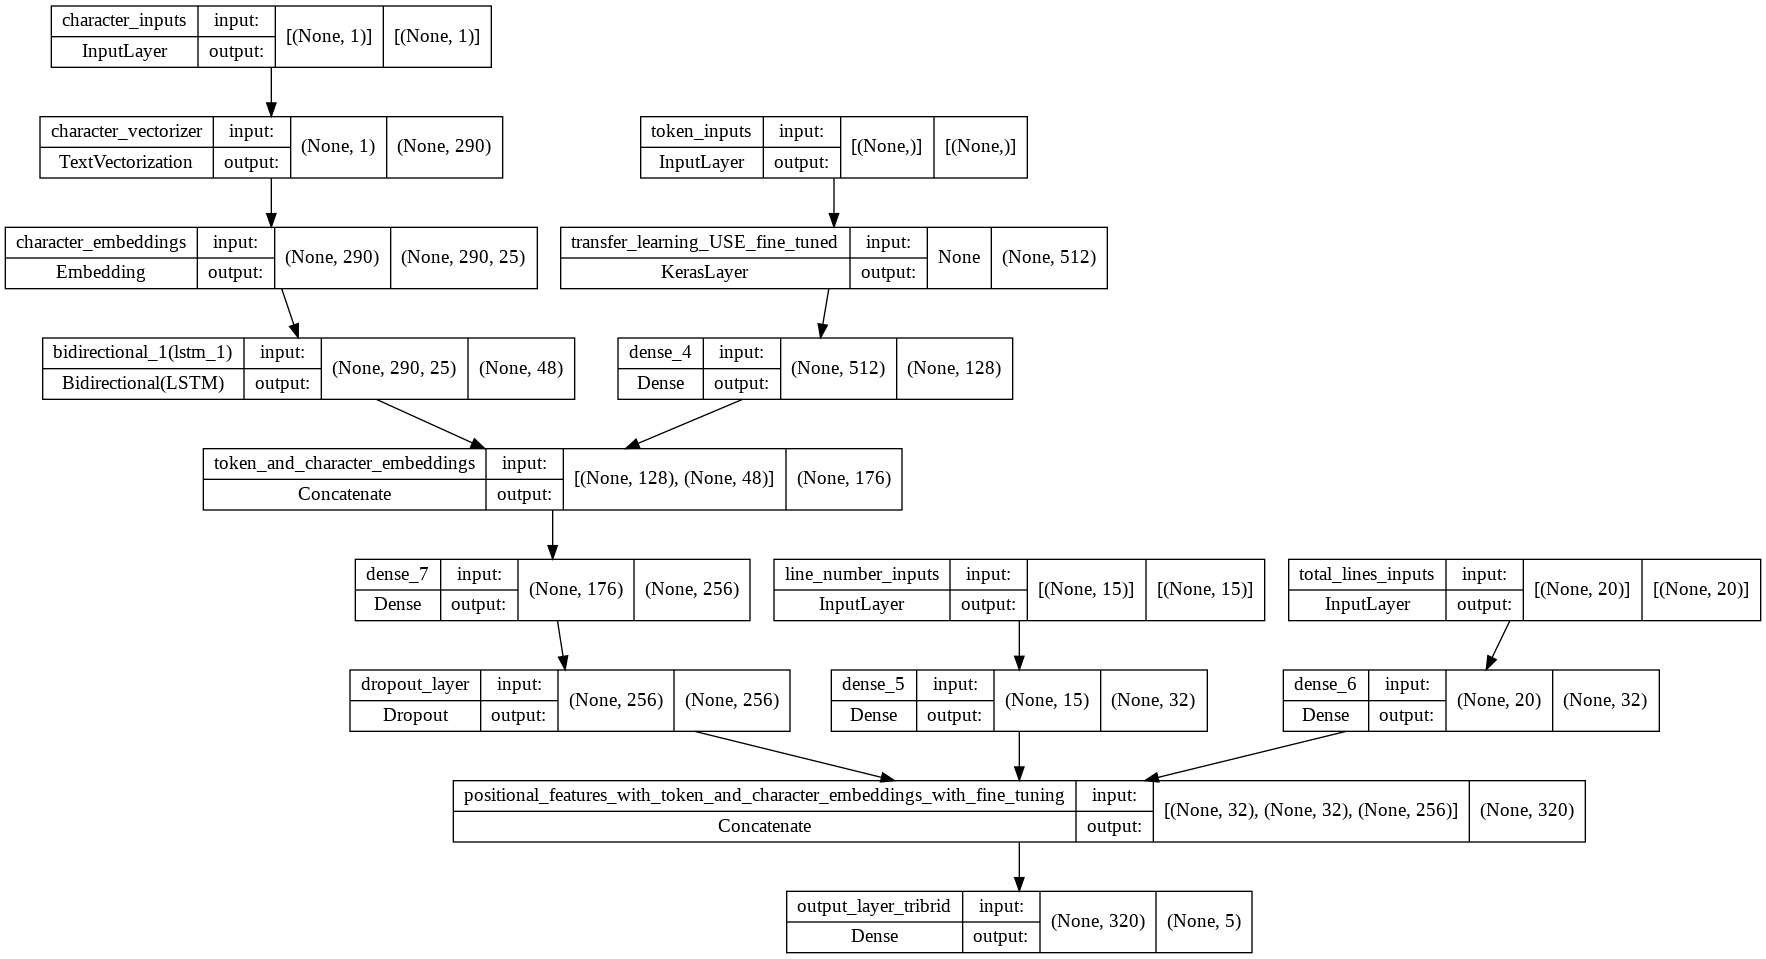

In [ ]:
plot_model(tribrid_model_whole_fine_tuned, show_shapes=True)

In [ ]:
tribrid_model_whole_fine_tuned.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

### Callbacks for Fine-Tuned Model

In [ ]:
model_checkpoint_path= 'checkpoints_fine_tuned'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_fine_tuning")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_fine_tuning/20220901-112655


In [ ]:
# history_tribrid_model_whole_fine_tuned= tribrid_model_whole_fine_tuned.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9045 - accuracy: 0.8529
Epoch 1: val_accuracy improved from -inf to 0.87442, saving model to checkpoints_fine_tuned
5627/5627 [==============================] - 1076s 188ms/step - loss: 0.9045 - accuracy: 0.8529 - val_loss: 0.8673 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.9347
Epoch 2: val_accuracy did not improve from 0.87442
5627/5627 [==============================] - 1043s 185ms/step - loss: 0.7835 - accuracy: 0.9347 - val_loss: 0.8997 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.9751
Epoch 3: val_accuracy did not improve from 0.87442

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5627/5627 [==============================] - 1042s 185ms/step - loss: 0.7197 - accuracy: 0.9751 - val_loss: 0.9198 - val_accuracy: 0

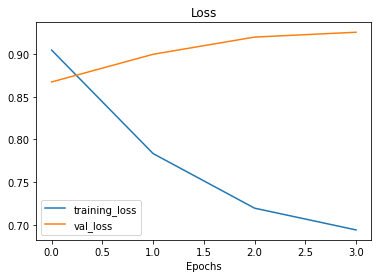

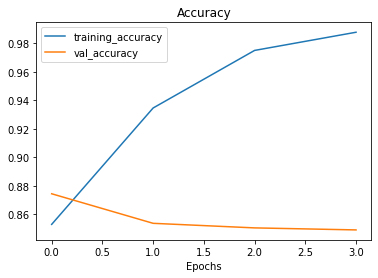

In [ ]:
plot_loss_curves(history_tribrid_model_whole_fine_tuned)

In [ ]:
# tribrid_model_whole_fine_tuned_pred_probs= tribrid_model_whole_fine_tuned.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_fine_tuned_preds= tf.argmax(tribrid_model_whole_fine_tuned_pred_probs, axis=1)
# tribrid_model_whole_fine_tuned_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_fine_tuned_results= calculate_results(val_labels_encoder, tribrid_model_whole_fine_tuned_preds)
# tribrid_model_whole_fine_tuned_results

In [ ]:
# tribrid_model_whole_results

NameError: ignored

## The `optimizer` used in the paper was `SGD()` and I used `Adam()` instead as it was reliable and I was using it from the start.

> Let's try SGD() optimizer instead of Adam() and see if the score of the model improves or not. Using the `Fine-Tuned` model, with `trainable=True`.

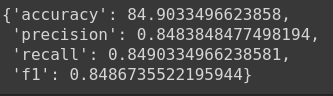

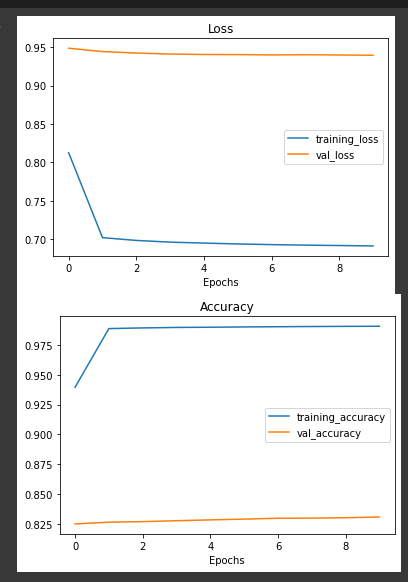

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder_trainable(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_fine_tuning_using_sgd")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_fine_tuned_using_sgd= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_fine_tuned_model_using_sgd")

In [ ]:
tribrid_model_whole_fine_tuned_using_sgd.summary()

Model: "tribrid_embedding_fine_tuned_model_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE_fine_tun  (None, 512)         25

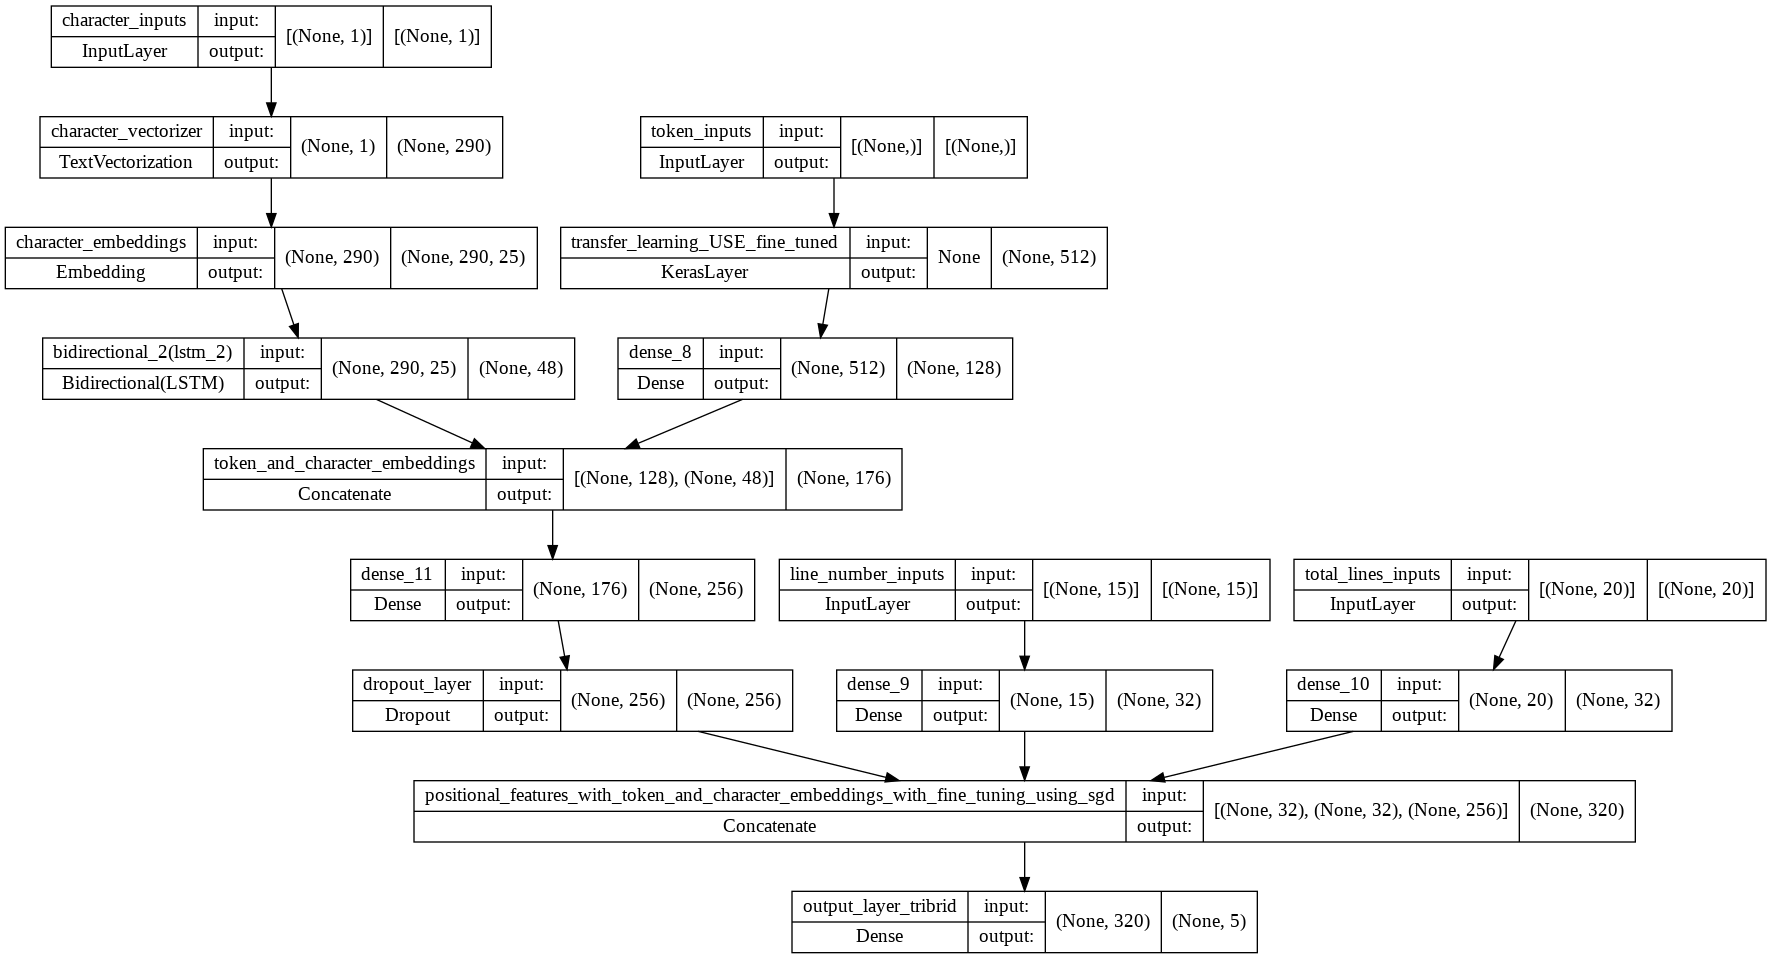

In [ ]:
plot_model(tribrid_model_whole_fine_tuned_using_sgd, show_shapes=True)

In [ ]:
tribrid_model_whole_fine_tuned_using_sgd.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

### Callbacks for Fine-Tuned model using `SGD()` optimizer

In [ ]:
model_checkpoint_path= 'checkpoints_fine_tuned_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_fine_tuning_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_fine_tuning_using_sgd/20220901-112750


In [ ]:
# history_tribrid_model_whole_fine_tuned_using_sgd= tribrid_model_whole_fine_tuned_using_sgd.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.9395
Epoch 1: val_accuracy improved from -inf to 0.82484, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 299s 52ms/step - loss: 0.8126 - accuracy: 0.9395 - val_loss: 0.9486 - val_accuracy: 0.8248 - lr: 0.0100
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.9887
Epoch 2: val_accuracy improved from 0.82484 to 0.82629, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 288s 51ms/step - loss: 0.7020 - accuracy: 0.9887 - val_loss: 0.9443 - val_accuracy: 0.8263 - lr: 0.0100
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.9893
Epoch 3: val_accuracy improved from 0.82629 to 0.82676, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 288s 51ms/step - loss: 0.6984 - accuracy: 0.9893 - 

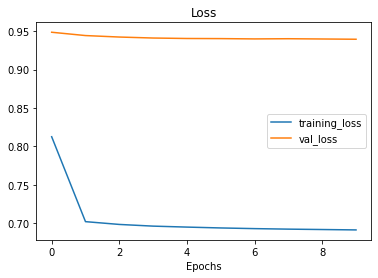

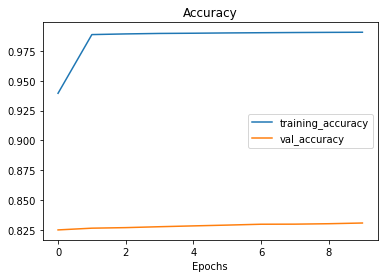

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_fine_tuned_using_sgd)

In [ ]:
# tribrid_model_whole_fine_tuned_using_sgd_pred_probs= tribrid_model_whole_fine_tuned_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_fine_tuned_using_sgd_preds= tf.argmax(tribrid_model_whole_fine_tuned_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_fine_tuned_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_fine_tuned_using_sgd_results= calculate_results(tribrid_model_whole_fine_tuned_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_fine_tuned_using_sgd_results

{'accuracy': 83.06302131603337,
 'precision': 0.8324775869117791,
 'recall': 0.8306302131603337,
 'f1': 0.8314538505220812}

In [ ]:
# tribrid_model_whole_results

NameError: ignored

In [ ]:
# tribrid_model_whole_fine_tuned_results

{'accuracy': 84.9033496623858,
 'precision': 0.8483848477498194,
 'recall': 0.8490334966238581,
 'f1': 0.8486735522195944}

## The `optimizer` used in the paper was `SGD()` and I used `Adam()` instead as it was reliable and I was using it from the start.

> Let's try SGD() optimizer instead of Adam() and see if the score of the model improves or not. Using the `Feature Extractor` model, with `trainable=False`.


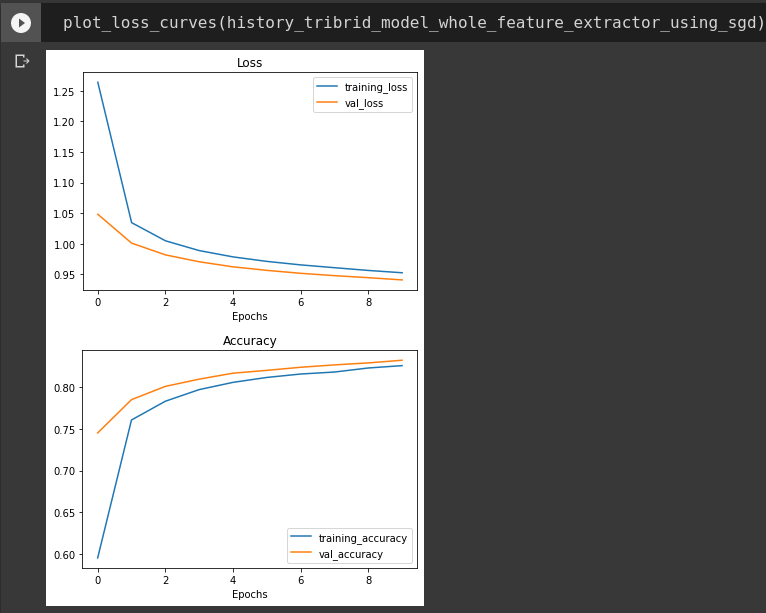

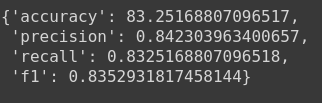

In [ ]:
universal_sentence_encoder= hub.KerasLayer(model_url, trainable= False, input_shape=[], dtype="string", name="transfer_learning_USE")

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_feature_extraction_using_sgd")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_feature_extractor_using_sgd= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_feature_extractor_using_sgd")

In [ ]:
tribrid_model_whole_feature_extractor_using_sgd.summary()

Model: "tribrid_embedding_feature_extractor_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE (KerasLa  (None, 512)         2

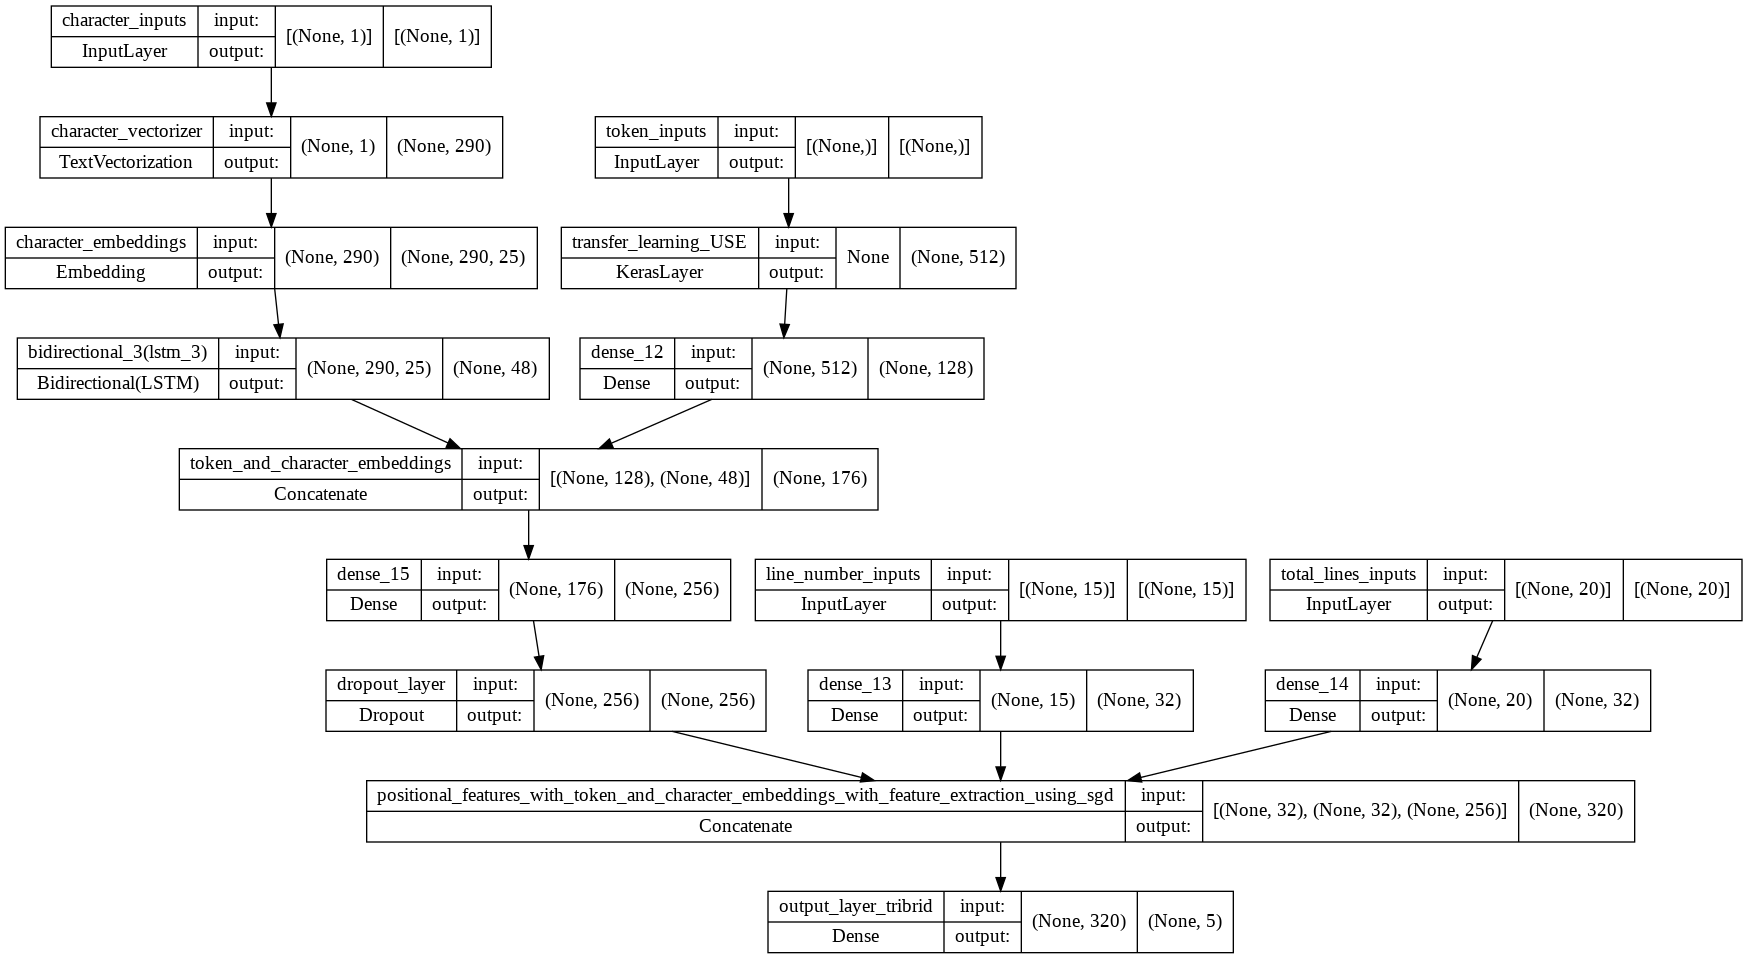

In [ ]:
plot_model(tribrid_model_whole_feature_extractor_using_sgd, show_shapes=True)

In [ ]:
tribrid_model_whole_feature_extractor_using_sgd.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

### Callbacks for Feature extractor model using SGD()

In [ ]:
model_checkpoint_path= 'checkpoints_feature_extractor_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_feature_extractor_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_feature_extractor_using_sgd/20220901-112924


In [ ]:
# history_tribrid_model_whole_feature_extractor_using_sgd= tribrid_model_whole_feature_extractor_using_sgd.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 1.2639 - accuracy: 0.5951
Epoch 1: val_accuracy improved from -inf to 0.74520, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 267s 46ms/step - loss: 1.2639 - accuracy: 0.5951 - val_loss: 1.0482 - val_accuracy: 0.7452 - lr: 0.0100
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 1.0345 - accuracy: 0.7608
Epoch 2: val_accuracy improved from 0.74520 to 0.78518, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 260s 46ms/step - loss: 1.0345 - accuracy: 0.7608 - val_loss: 1.0010 - val_accuracy: 0.7852 - lr: 0.0100
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.7833
Epoch 3: val_accuracy improved from 0.78518 to 0.80111, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 258s 46ms/step - loss: 1.0048 

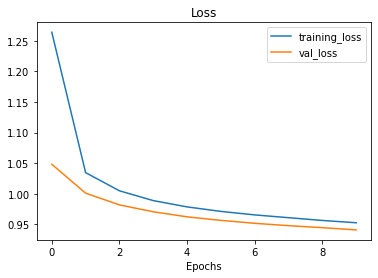

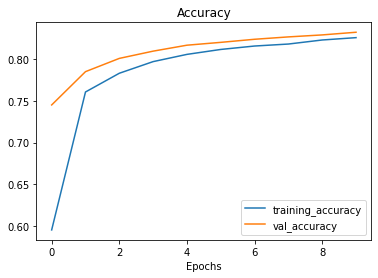

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_feature_extractor_using_sgd)

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_pred_probs= tribrid_model_whole_feature_extractor_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_feature_extractor_using_sgd_preds= tf.argmax(tribrid_model_whole_feature_extractor_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_results= calculate_results(tribrid_model_whole_feature_extractor_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_feature_extractor_using_sgd_results

{'accuracy': 83.25168807096517,
 'precision': 0.842303963400657,
 'recall': 0.8325168807096518,
 'f1': 0.8352931817458144}

## Same Model(`tribrid_model_whole_feature_extractor_using_sgd`) as above but trained for longer, `epochs=20`

### Results

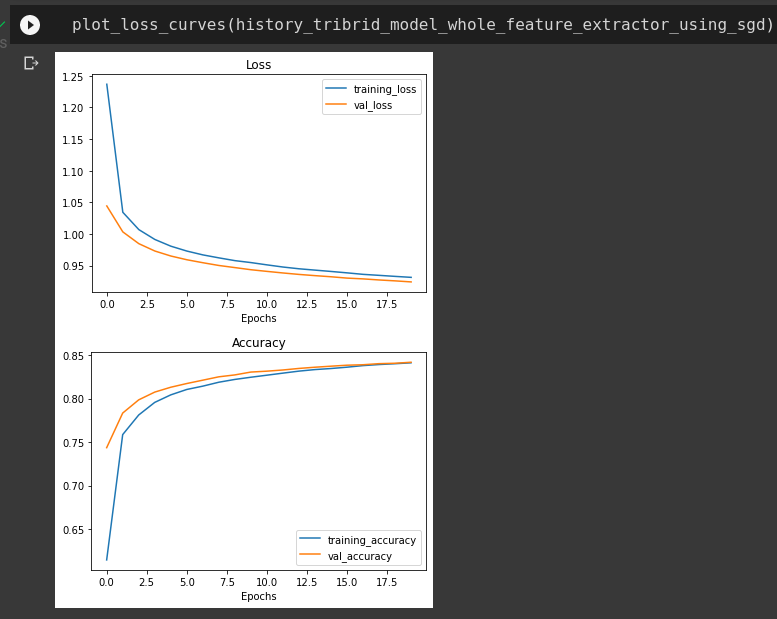

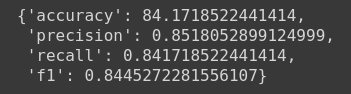


In [ ]:
# history_tribrid_model_whole_feature_extractor_using_sgd= tribrid_model_whole_feature_extractor_using_sgd.fit(train_line_total_token_char_dataset, epochs=20, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/20
5627/5627 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.6145
Epoch 1: val_accuracy improved from -inf to 0.74351, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 280s 47ms/step - loss: 1.2367 - accuracy: 0.6145 - val_loss: 1.0443 - val_accuracy: 0.7435 - lr: 0.0100
Epoch 2/20
5627/5627 [==============================] - ETA: 0s - loss: 1.0343 - accuracy: 0.7585
Epoch 2: val_accuracy improved from 0.74351 to 0.78330, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 265s 47ms/step - loss: 1.0343 - accuracy: 0.7585 - val_loss: 1.0033 - val_accuracy: 0.7833 - lr: 0.0100
Epoch 3/20
5627/5627 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.7811
Epoch 3: val_accuracy improved from 0.78330 to 0.79849, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 260s 46ms/step - loss: 1.0069 

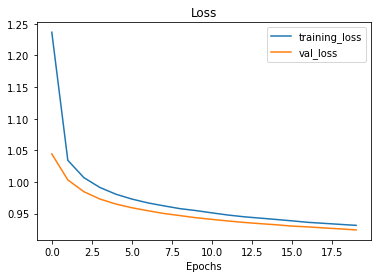

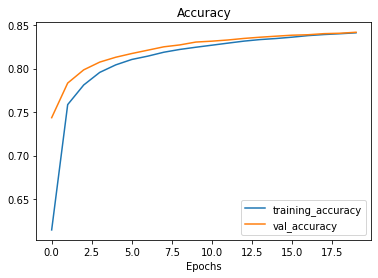

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_feature_extractor_using_sgd)

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_pred_probs= tribrid_model_whole_feature_extractor_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_feature_extractor_using_sgd_preds= tf.argmax(tribrid_model_whole_feature_extractor_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_results= calculate_results(tribrid_model_whole_feature_extractor_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_feature_extractor_using_sgd_results

{'accuracy': 84.1718522441414,
 'precision': 0.8518052899124999,
 'recall': 0.841718522441414,
 'f1': 0.8445272281556107}

## Pre-trained `Glove Embeddings`

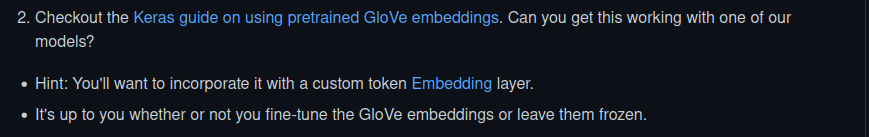

### Getting the Pre-trained `Glove Embeddings`

* Link -> https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

unzip_data('glove.6B.zip')

--2022-09-03 08:42:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-03 08:42:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-03 08:42:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

### Getting the paths of the glove embeddings

In [ ]:
glove_path= 'glove.6B.100d.txt'

embedding_index={}

# Making a dictionary representation of the words(s -> [8,48...])

with open(glove_path) as f:
  for line in f:
    # Getting the words and coeffecients of the variable
    word, coefs= line.split(maxsplit=1)
    coefs= np.fromstring(coefs, 'f', sep=' ')

    # Adding the coeffecient to the embedding dict
    embedding_index[word]= coefs

len(embedding_index)

400000

### Getting the sentences and characters

In [ ]:
train_df.head()

target                                               text  line_number  \
0  OBJECTIVE  to investigate the efficacy of @ weeks of dail...            0   
1    METHODS  a total of @ patients with primary knee oa wer...            1   
2    METHODS  outcome measures included pain reduction and i...            2   
3    METHODS  pain was assessed using the visual analog pain...            3   
4    METHODS  secondary outcome measures included the wester...            4   

   total_lines  
0           11  
1           11  
2           11  
3           11  
4           11

In [ ]:
np.percentile(len(train_df['text']), 95)

180040.0

In [ ]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
train_chars= [split_sentences(sentence) for sentence in train_sentences]
val_chars= [split_sentences(sentence) for sentence in val_sentences]

In [ ]:
char_lens= [len(sentence) for sentence in train_sentences]
np.percentile(char_lens, 95)

290.0

In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
text_vocab= text_vectorizer.get_vocabulary()
len(text_vocab)

64841

### Getting the dict mapping word --> index 

In [ ]:
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

### Creating a function that will give us a embedding matrix 

In [ ]:
def get_glove_embedding_matrix(num_tokens , embedding_dim , word_index):

  # Defining the hits and misses here 
  hits , misses = 0 , 0

  # Prepare the embedding matrix 
  embedding_matrix = np.zeros((num_tokens , embedding_dim ))
  for word , i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 
      hits += 1 
    else:
      misses += 1 

  return embedding_matrix , hits , misses

### Embedding matrix

In [ ]:
num_tokens_text = len(text_vocab) + 2 
embedding_dim = 100
sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)

print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


### Adding the embedding matrix to our Embedding layer (Sentence and characters)

In [ ]:
sen_embedding_layer = Embedding(num_tokens_text , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                            trainable = False )

### Datasets for both sentences and characters

In [ ]:
train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

In [ ]:
train_sen_vectors, val_sen_vectors

(array([[   6,  331,    2, ...,    0,    0,    0],
        [   8,   76,    4, ...,    0,    0,    0],
        [  86,  213,  121, ...,    0,    0,    0],
        ...,
        [  54,  667,   55, ...,    0,    0,    0],
        [  34,    7,  165, ...,    0,    0,    0],
        [1072,  388,    7, ...,    0,    0,    0]]),
 array([[ 3242,  6471,     6, ...,     0,     0,     0],
        [  185,    20,    31, ...,     0,     0,     0],
        [   43,  1193,     6, ...,     0,     0,     0],
        ...,
        [ 1088,   334,     4, ...,     0,     0,     0],
        [  162,     4,   142, ...,     0,     0,     0],
        [ 1644,    22, 16314, ...,     0,     0,     0]]))

In [ ]:
train_sen_vectors.shape

(180040, 55)

### One Hot Encoding the Glove Embedding datasets

> With this we can use `CategoricalCrossentropy(label_smoothing=0.2)` when compiling the model and reduce the `overfitting` of the model.

### Before 

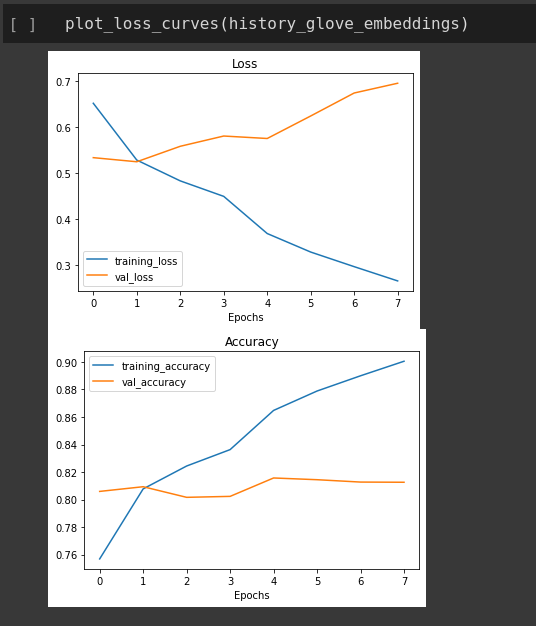


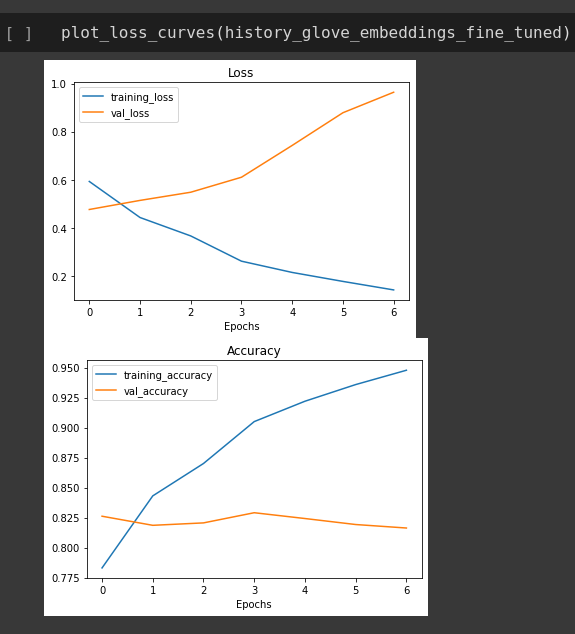


### After

> Not possible as the text are very big/lengthy to one-hot



In [ ]:
# train_sen_vectors_one_hot= one_hot_encoder.fit_transform(train_df['text'].to_numpy().reshape(-1,1))
# val_sen_vectors_one_hot= one_hot_encoder.fit_transform(val_df['text'].to_numpy().reshape(-1,1))

# train_sen_vectors_one_hot[0], train_sen_vectors_one_hot.shape

### Training and validation dataset 

In [ ]:
train_labels_encoder

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors_one_hot , train_labels_encoder))
# val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors_one_hot , val_labels_encoder))


train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoder))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoder))

train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(55,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Applying the batch size and prefetching (performance optimization)

In [ ]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds,  val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
train_sen_vectors[0].shape

(55,)

## Glove Embeddings Model with feature extraction model, `trainable=False`.


### Before `L2 Regularizers`

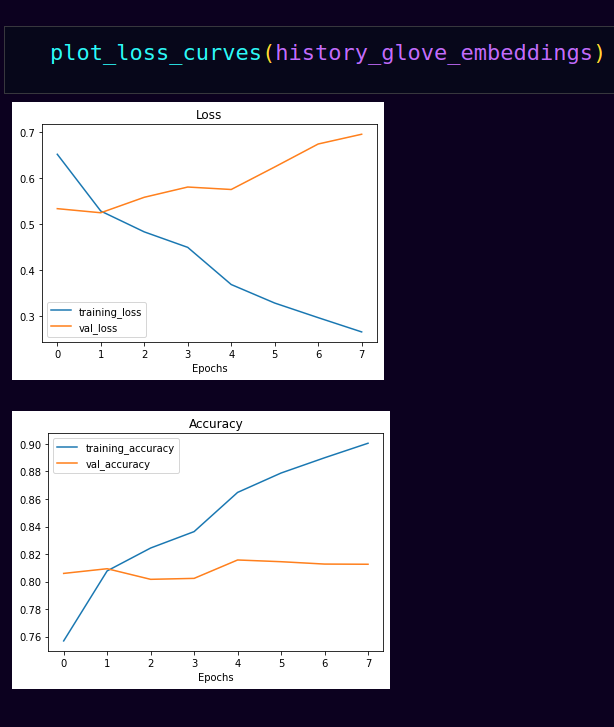


### After, with only L2 Regularizer

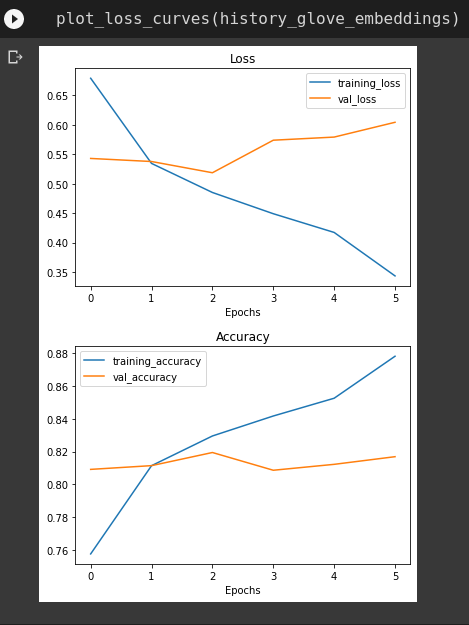



#### After Adding both L1 and L2 Regularizers

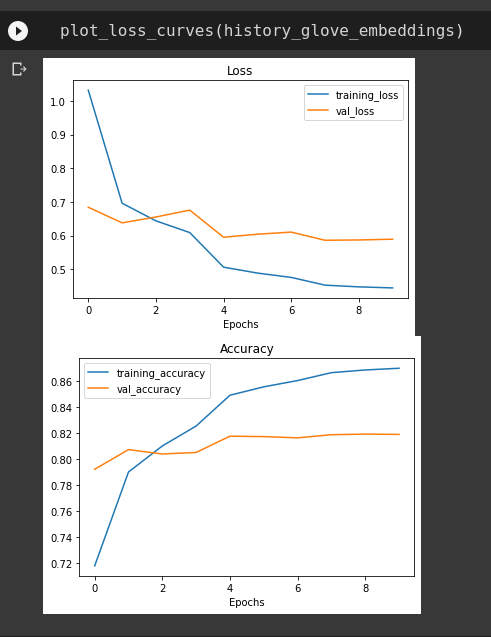



In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L2(0.001))(x)
x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)

glove_model = tf.keras.Model(input , output, name="glove_embeddings")
glove_model.summary()

Model: "glove_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 128)        0         
 1D)                                              

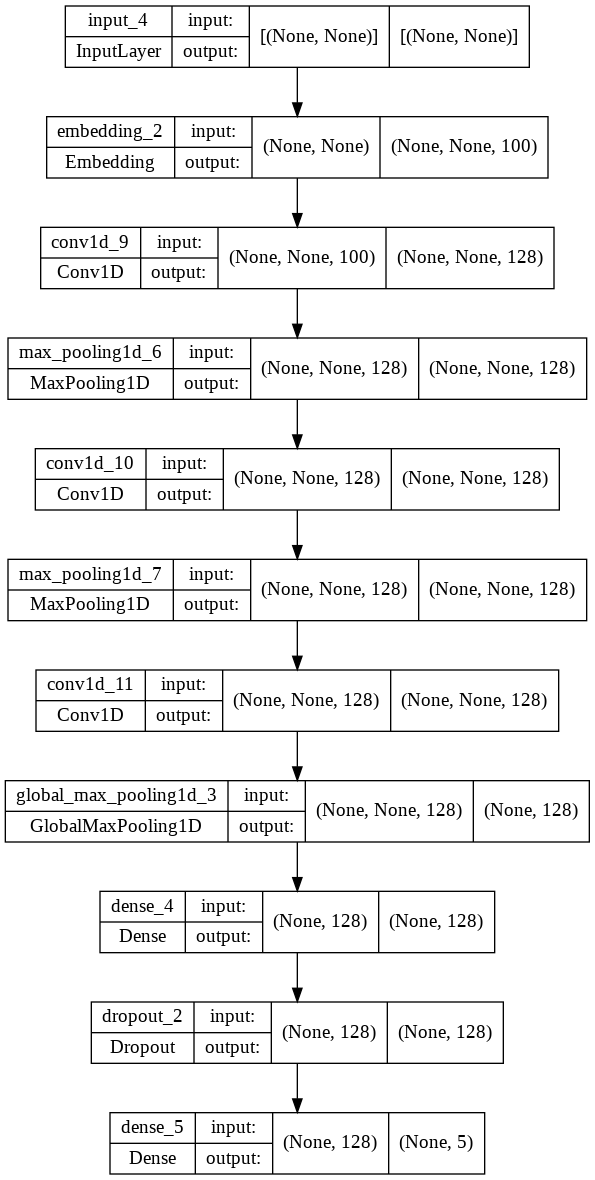

In [ ]:
plot_model(glove_model, show_shapes=True)

### Callbacks for Glove Embeddings model

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_model'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model/20220902-071627


In [ ]:
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

history_glove_embeddings=glove_model.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5624/5627 [============================>.] - ETA: 0s - loss: 1.0306 - accuracy: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.79111, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 26s 5ms/step - loss: 1.0305 - accuracy: 0.7165 - val_loss: 0.6685 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 2/10
5623/5627 [============================>.] - ETA: 0s - loss: 0.6963 - accuracy: 0.7884
Epoch 2: val_accuracy improved from 0.79111 to 0.80051, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 25s 5ms/step - loss: 0.6963 - accuracy: 0.7884 - val_loss: 0.6601 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 3/10
5619/5627 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.8090
Epoch 3: val_accuracy improved from 0.80051 to 0.80061, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 25s 5ms/step - loss: 0.6437 - accuracy: 0.8090 - val

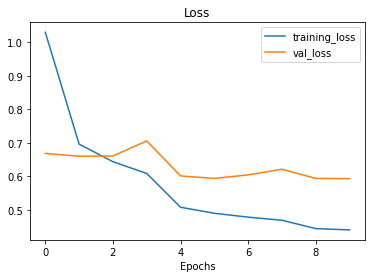

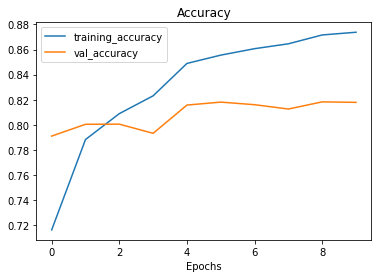

In [ ]:
plot_loss_curves(history_glove_embeddings)

In [ ]:
glove_embeddings_feature_extractor_pred_probs= glove_model.predict(val_ds)
glove_embeddings_feature_extractor_preds= tf.argmax(glove_embeddings_feature_extractor_pred_probs, axis=1)
glove_embeddings_feature_extractor_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 1])>

In [ ]:
glove_embeddings_feature_extractor_results= calculate_results(glove_embeddings_feature_extractor_preds, val_labels_encoder)
glove_embeddings_feature_extractor_results

{'accuracy': 81.79531312061432,
 'precision': 0.8291076518815699,
 'recall': 0.8179531312061432,
 'f1': 0.8204137371153005}

## Glove Embeddings with Feature Extraction model using `SGD()`

### Before 

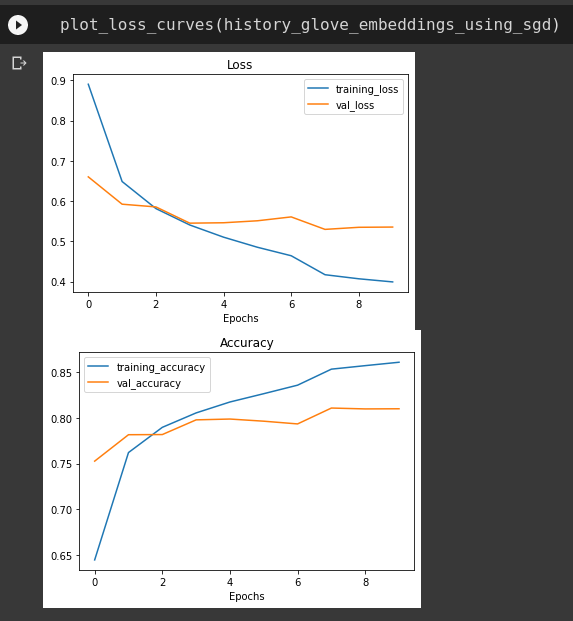

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)

glove_model_using_sgd = tf.keras.Model(input , output)

In [ ]:
glove_model_using_sgd.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6484300   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

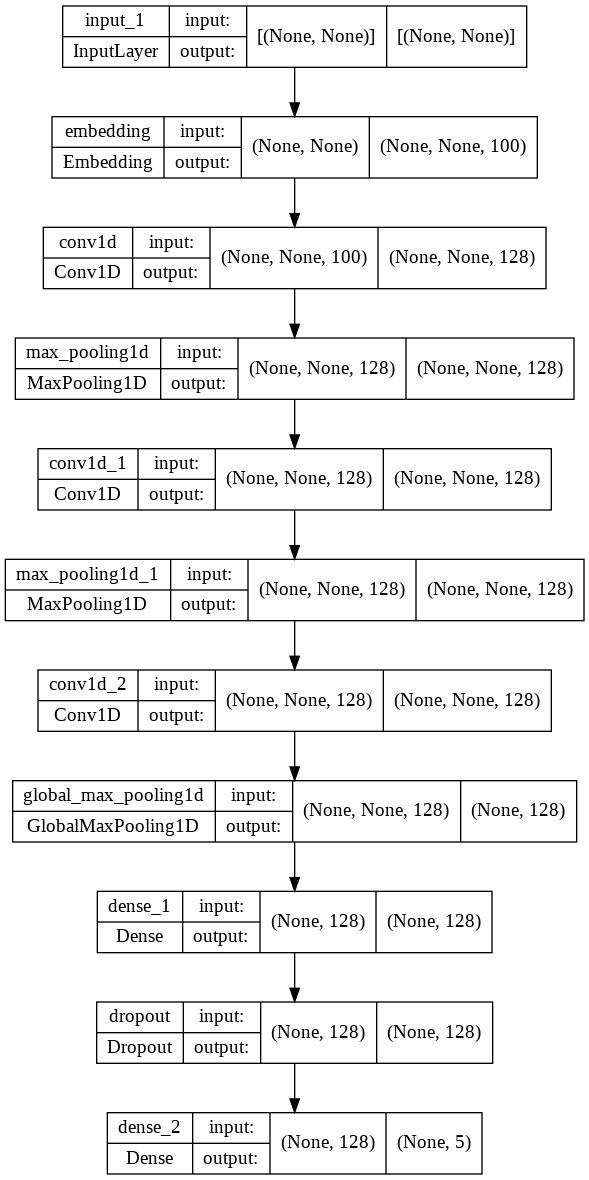

In [ ]:
plot_model(glove_model_using_sgd, show_shapes=True)

### Callbacks for Glove Embeddings model

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model_using_sgd/20220903-084555


In [ ]:
glove_model_using_sgd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.SGD(), 
                     metrics = ['accuracy'])

history_glove_embeddings_using_sgd=glove_model_using_sgd.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 2.4783 - accuracy: 0.4363
Epoch 1: val_accuracy improved from -inf to 0.44568, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 39s 5ms/step - loss: 2.4783 - accuracy: 0.4363 - val_loss: 1.2023 - val_accuracy: 0.4457 - lr: 0.0100
Epoch 2/10
5619/5627 [============================>.] - ETA: 0s - loss: 1.1970 - accuracy: 0.4667
Epoch 2: val_accuracy improved from 0.44568 to 0.46068, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 25s 4ms/step - loss: 1.1970 - accuracy: 0.4668 - val_loss: 1.1496 - val_accuracy: 0.4607 - lr: 0.0100
Epoch 3/10
5624/5627 [============================>.] - ETA: 0s - loss: 1.1503 - accuracy: 0.4952
Epoch 3: val_accuracy improved from 0.46068 to 0.50761, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 25s 5ms/step - loss: 1

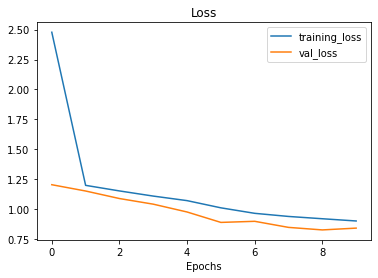

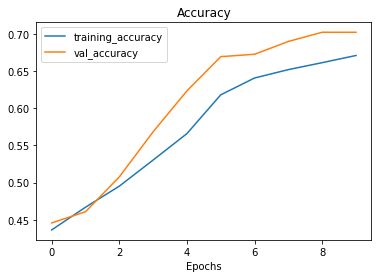

In [ ]:
plot_loss_curves(history_glove_embeddings_using_sgd)

In [ ]:
glove_embeddings_feature_extractor_using_sgd_pred_probs= glove_model_using_sgd.predict(val_ds)
glove_embeddings_feature_extractor_using_sgd_preds= tf.argmax(glove_embeddings_feature_extractor_using_sgd_pred_probs, axis=1)
glove_embeddings_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 0])>

In [ ]:
glove_embeddings_feature_extractor_using_sgd_results= calculate_results(glove_embeddings_feature_extractor_using_sgd_preds, val_labels_encoder)
glove_embeddings_feature_extractor_using_sgd_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 70.22706209453197,
 'precision': 0.8104430586328604,
 'recall': 0.7022706209453198,
 'f1': 0.7378912447565571}

## Glove Embeddings Model with Fine-Tuned model, `trainable=True`.

### Before

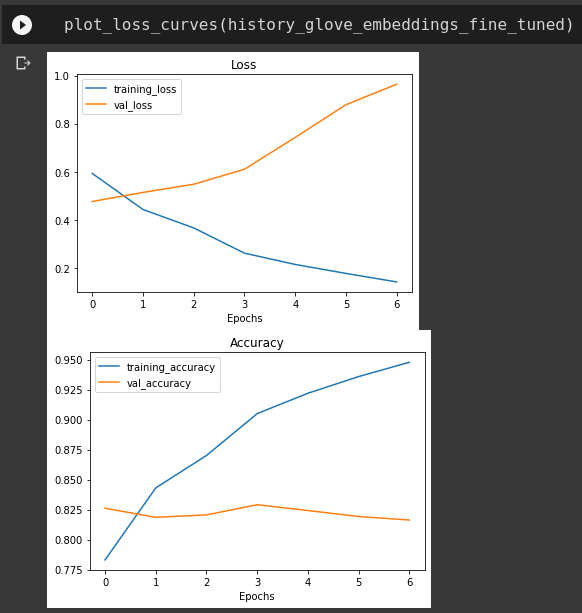


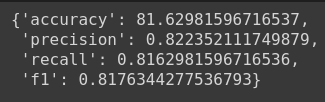

In [ ]:
sen_embedding_layer_trainable = Embedding(num_tokens_text , embedding_dim , embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , trainable = True)

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer_trainable(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)

glove_model_trainable = tf.keras.Model(input , output)

In [ ]:
glove_model_trainable.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

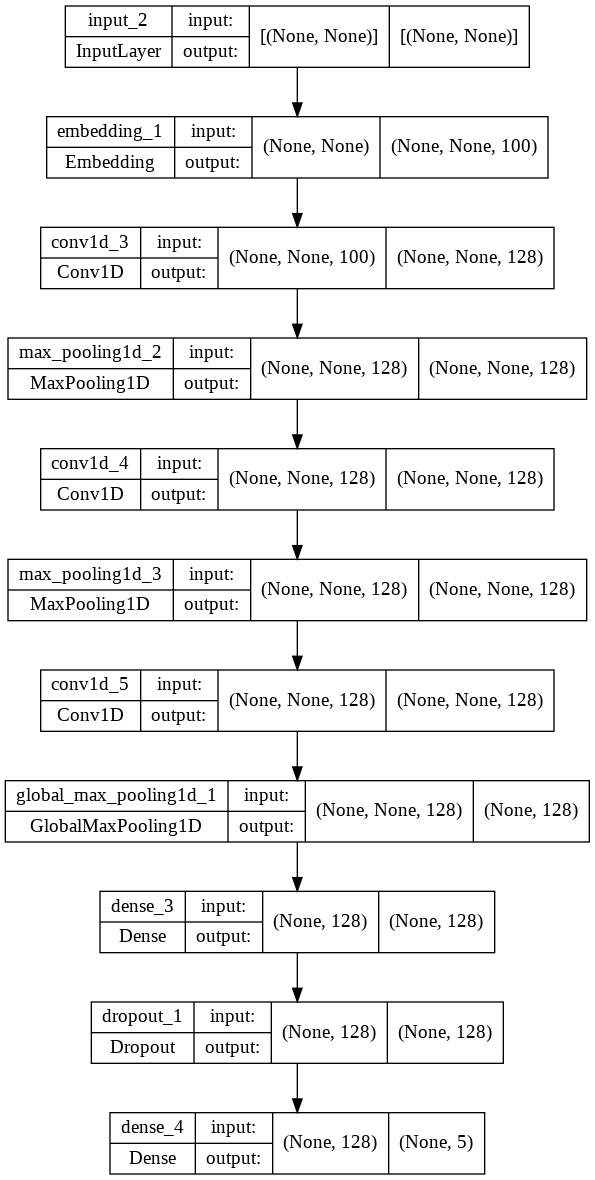

In [ ]:
plot_model(glove_model_trainable, show_shapes=True)

### Callbacks for glove embeddings with Fine-Tuned Model

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_model_fine_tuned'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model_fine_tuned")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model_fine_tuned/20220903-085245


### Training the glove embeddings fine-tuned model

In [ ]:
glove_model_trainable.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

history_glove_embeddings_fine_tuned=glove_model_trainable.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5625/5627 [============================>.] - ETA: 0s - loss: 0.9495 - accuracy: 0.7514
Epoch 1: val_accuracy improved from -inf to 0.81193, saving model to checkpoints_glove_embedding_model_fine_tuned
5627/5627 [==============================] - 46s 8ms/step - loss: 0.9495 - accuracy: 0.7514 - val_loss: 0.6238 - val_accuracy: 0.8119 - lr: 0.0010
Epoch 2/10
5623/5627 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.8289
Epoch 2: val_accuracy improved from 0.81193 to 0.81905, saving model to checkpoints_glove_embedding_model_fine_tuned
5627/5627 [==============================] - 45s 8ms/step - loss: 0.5980 - accuracy: 0.8289 - val_loss: 0.6106 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/10
5622/5627 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.8592
Epoch 3: val_accuracy improved from 0.81905 to 0.82206, saving model to checkpoints_glove_embedding_model_fine_tuned
5627/5627 [==============================] - 45s 8ms/step - loss

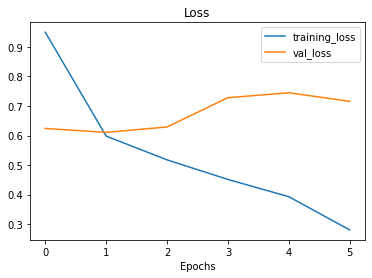

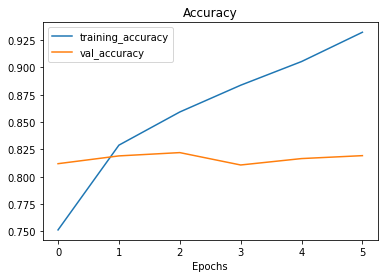

In [ ]:
plot_loss_curves(history_glove_embeddings_fine_tuned)

In [ ]:
glove_embeddings_fine_tuned_pred_probs= glove_model_trainable.predict(val_ds)
glove_embeddings_fine_tuned_preds= tf.argmax(glove_embeddings_fine_tuned_pred_probs, axis=1)
glove_embeddings_fine_tuned_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 0, ..., 4, 1, 1])>

In [ ]:
glove_embeddings_fine_tuned_results= calculate_results(glove_embeddings_fine_tuned_preds, val_labels_encoder)
glove_embeddings_fine_tuned_results

{'accuracy': 81.92771084337349,
 'precision': 0.8231181187397637,
 'recall': 0.8192771084337349,
 'f1': 0.8205788233851646}

## Glove Embeddings Model with Fine-Tuned model using `SGD()`, `trainable=True`.


### Before

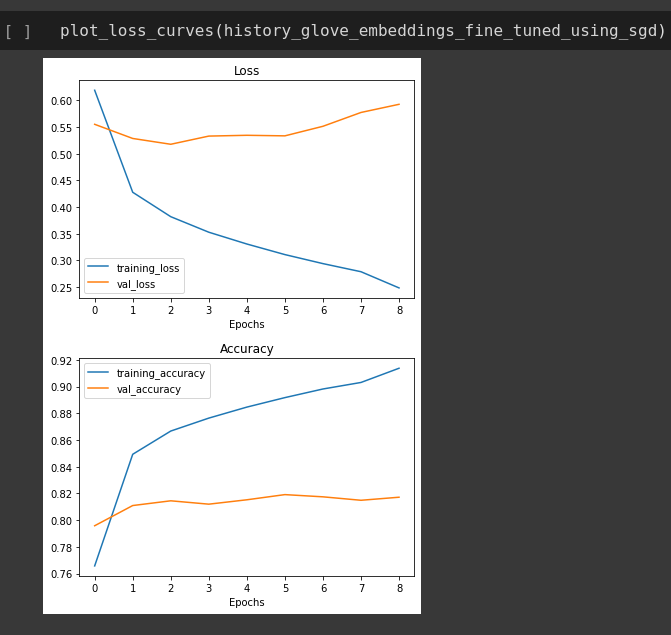


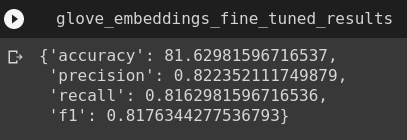


### After

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer_trainable(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)

glove_model_trainable_using_sgd = tf.keras.Model(input , output)

In [ ]:
glove_model_trainable_using_sgd.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

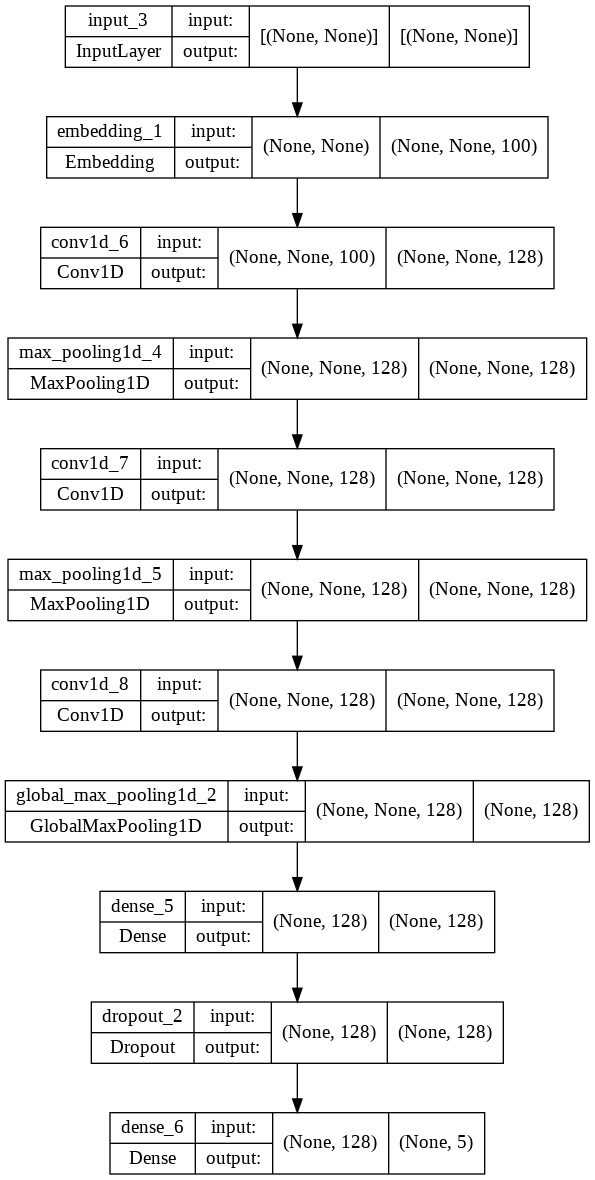

In [ ]:
plot_model(glove_model_trainable_using_sgd, show_shapes=True)

### Callbacks for fine-tuned model using SGD()

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_fine_tuned_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_fine_tuned_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_fine_tuned_model_using_sgd/20220903-085913


### Training the glove embeddings fine-tuned model using `SGD()`

In [ ]:
glove_model_trainable_using_sgd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.SGD(), 
                     metrics = ['accuracy'])

history_glove_embeddings_fine_tuned_using_sgd=glove_model_trainable_using_sgd.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5618/5627 [============================>.] - ETA: 0s - loss: 2.1229 - accuracy: 0.7197
Epoch 1: val_accuracy improved from -inf to 0.75205, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [==============================] - 28s 5ms/step - loss: 2.1210 - accuracy: 0.7197 - val_loss: 0.8097 - val_accuracy: 0.7521 - lr: 0.0100
Epoch 2/10
5616/5627 [============================>.] - ETA: 0s - loss: 0.7338 - accuracy: 0.7833
Epoch 2: val_accuracy improved from 0.75205 to 0.75957, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [==============================] - 27s 5ms/step - loss: 0.7338 - accuracy: 0.7833 - val_loss: 0.7751 - val_accuracy: 0.7596 - lr: 0.0100
Epoch 3/10
5625/5627 [============================>.] - ETA: 0s - loss: 0.6705 - accuracy: 0.8066
Epoch 3: val_accuracy improved from 0.75957 to 0.77559, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [=======================

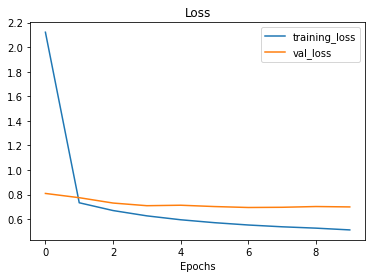

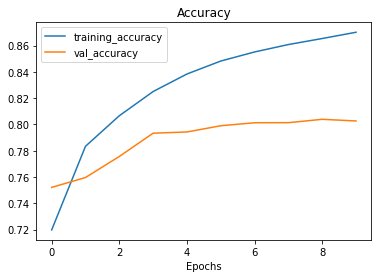

In [ ]:
plot_loss_curves(history_glove_embeddings_fine_tuned_using_sgd)

In [ ]:
glove_embeddings_fine_tuned_using_sgd_pred_probs= glove_model_trainable_using_sgd.predict(val_ds)
glove_embeddings_fine_tuned_using_sgd_preds= tf.argmax(glove_embeddings_fine_tuned_using_sgd_pred_probs, axis=1)
glove_embeddings_fine_tuned_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 0, 0, ..., 4, 0, 1])>

In [ ]:
glove_embeddings_fine_tuned_using_sgd_results= calculate_results(glove_embeddings_fine_tuned_using_sgd_preds, val_labels_encoder)
glove_embeddings_fine_tuned_using_sgd_results

{'accuracy': 80.25949953660798,
 'precision': 0.8082525433979021,
 'recall': 0.8025949953660797,
 'f1': 0.8032402924787841}

In [ ]:
glove_embeddings_fine_tuned_results

{'accuracy': 81.62981596716537,
 'precision': 0.822352111749879,
 'recall': 0.8162981596716536,
 'f1': 0.8176344277536793}

## Replacing the Pre-trained `USE` model with `BERT PubMed Expert` model.

> Both the models are from Tensorflow hub

* Link(`Bert Pubmed Expert layer`) -> https://tfhub.dev/google/experts/bert/pubmed/2

* Link(`Bert Preprocessing layer`) -> https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

> Have to Train it on `10%` of the training dataset and `10%` on the validation dataset, otherwise it will take too long to train a single epoch of the model, which will take aroung `30mins` for each epoch. Just to save time and make it easier, I trained on `10%` of the dataset and colab will also disconnect if I train on the whole dataset.

> The evaluation of the model was done on `100%` of the validation dataset


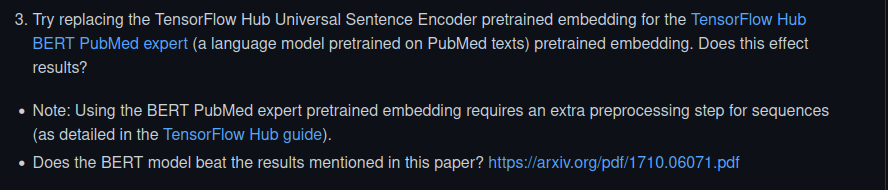

In [2]:
!pip install tensorflow_text
import tensorflow_text as text  # Imports TF ops for preprocessing.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 30.2 MB/s 
     |████████████████████████████████| 511.8 MB 8.4 kB/s 
     |████████████████████████████████| 1.6 MB 64.1 MB/s 
     |████████████████████████████████| 438 kB 76.5 MB/s 
     |████████████████████████████████| 5.8 MB 54.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

### Model Link

In [53]:
model_url='https://tfhub.dev/google/experts/bert/pubmed/2'

## Bert Expert Pubmed Model with `trainable=False`

### Before

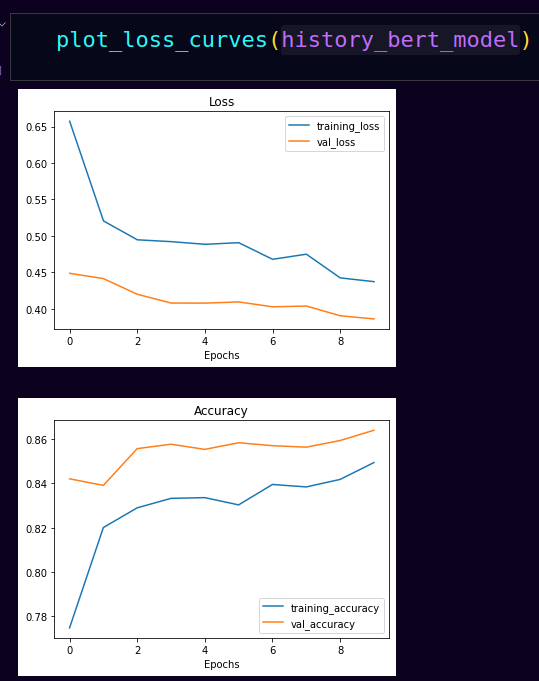


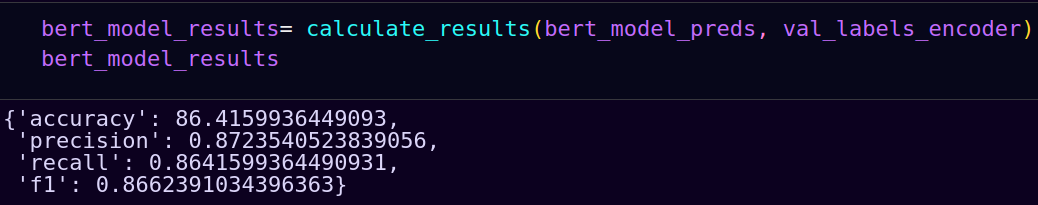

### After adding `L1 and L2 regularizerts`

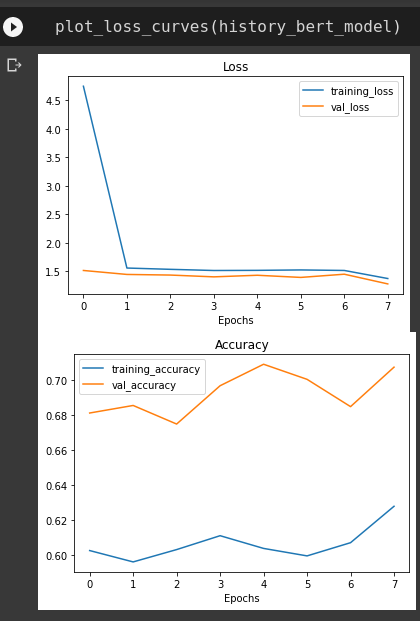

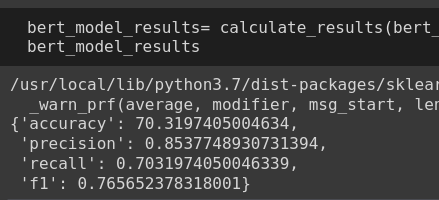

In [54]:
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = False , name = 'pubmed_bert_preprocessor')
preprocessing_layer

In [55]:
bert_expert_pubmed_layer= hub.KerasLayer(model_url, trainable=False, name="bert_expert_pubmed_layer")
bert_expert_pubmed_layer

In [56]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
# x=layers.Dense(128, activation='relu', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(bert_embedding['pooled_output'])
x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
# outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)

bert_model= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer")

In [57]:
print(f'bert embedding shape: {bert_embedding}')
bert_embedding['pooled_output']

bert embedding shape: {'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by lay

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>

In [58]:
bert_model.summary()

Model: "bert_expert_pubmed_layer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_word_ids':   0          ['input_sentences[0][0]']        
 sLayer)                        (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                   

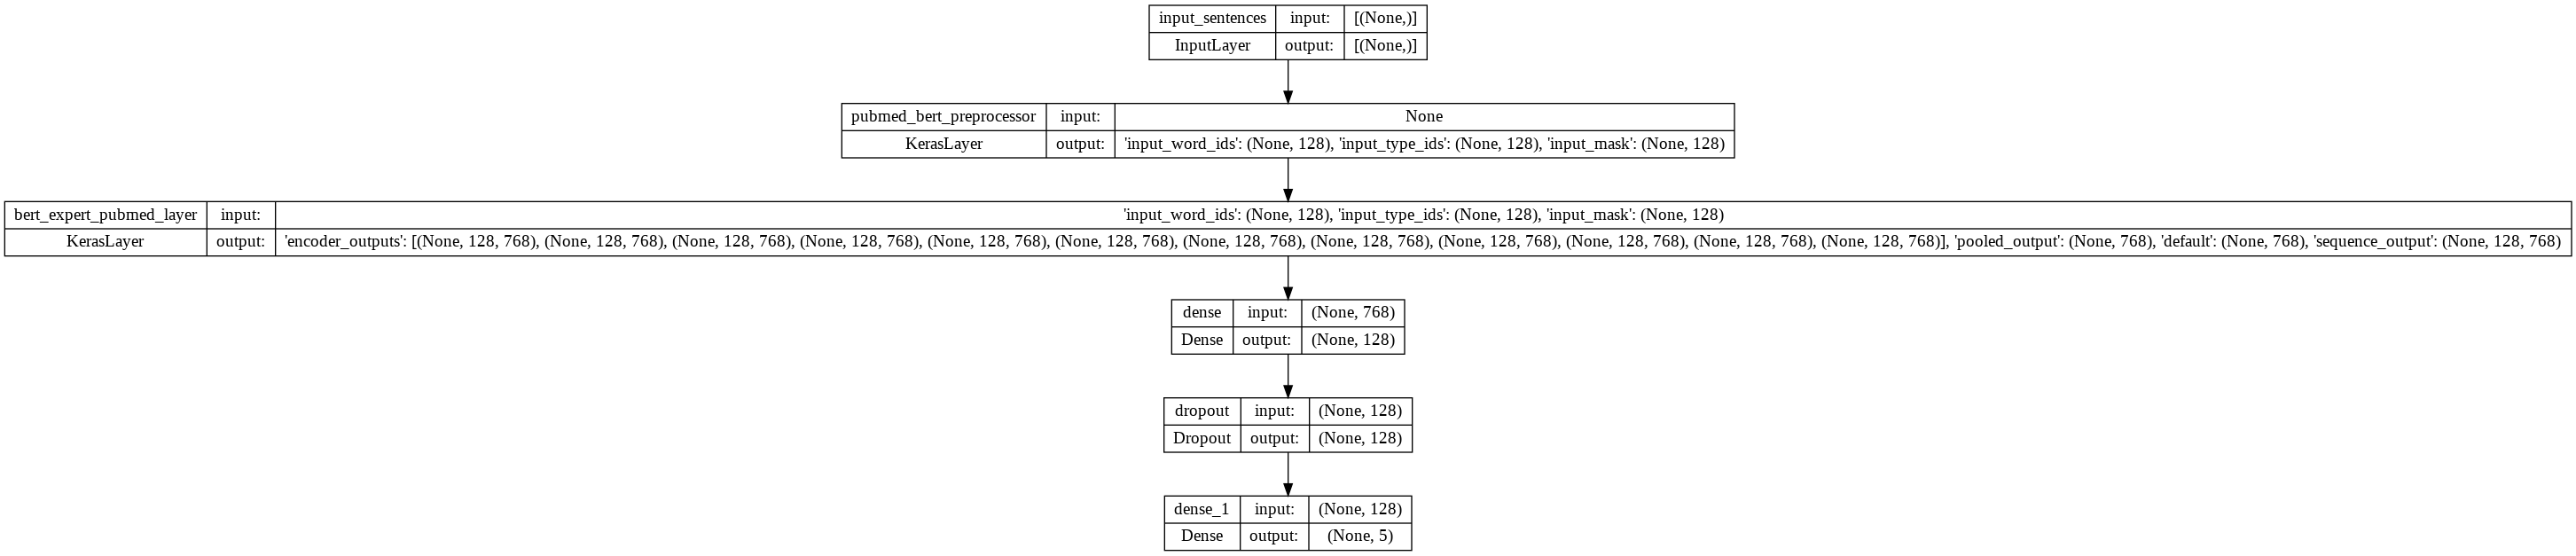

In [59]:
plot_model(bert_model, show_shapes=True)

### Bert Pubmed model datasets

In [60]:
train_sen_ds= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoder))
val_sen_ds= tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoder))

train_sen_ds= train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_sen_ds= val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [61]:
train_sen_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Callbacks for Bert Model

In [62]:
model_checkpoint_path= 'checkpoints_bert_model'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model/20220904-041233


In [63]:
bert_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model= bert_model.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.7774
Epoch 1: val_accuracy improved from -inf to 0.83810, saving model to checkpoints_bert_model
562/562 [==============================] - 232s 394ms/step - loss: 0.6438 - accuracy: 0.7774 - val_loss: 0.4503 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.8230
Epoch 2: val_accuracy did not improve from 0.83810
562/562 [==============================] - 211s 375ms/step - loss: 0.5194 - accuracy: 0.8230 - val_loss: 0.4420 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.4983 - accuracy: 0.8267
Epoch 3: val_accuracy improved from 0.83810 to 0.85372, saving model to checkpoints_bert_model
562/562 [==============================] - 213s 379ms/step - loss: 0.4983 - accuracy: 0.8267 - val_loss: 0.4194 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 4/10
562/562 [==========

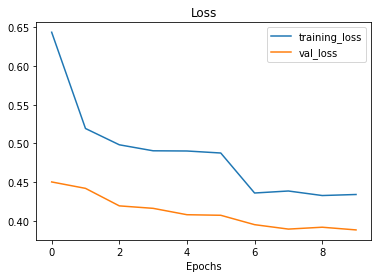

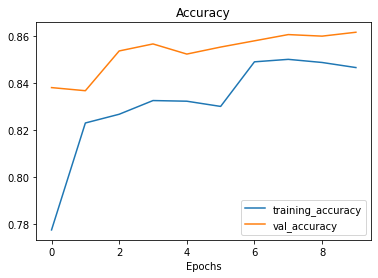

In [64]:
plot_loss_curves(history_bert_model)

In [66]:
bert_model_pred_probs= bert_model.predict(val_sen_ds)
bert_model_preds= tf.argmax(bert_model_pred_probs, axis=1)
bert_model_preds

945/945 [==============================] - 301s 318ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 0, ..., 4, 1, 1])>

In [67]:
bert_model_results= calculate_results(bert_model_preds, val_labels_encoder)
bert_model_results

{'accuracy': 86.35972461273667,
 'precision': 0.8711757728385985,
 'recall': 0.8635972461273667,
 'f1': 0.8659249750160055}

## Bert Expert Pubmed Model with trainable=False, using `L1 regularizer`

### Default value 

> In this case, the default value used is `l1=0.01`

### Results

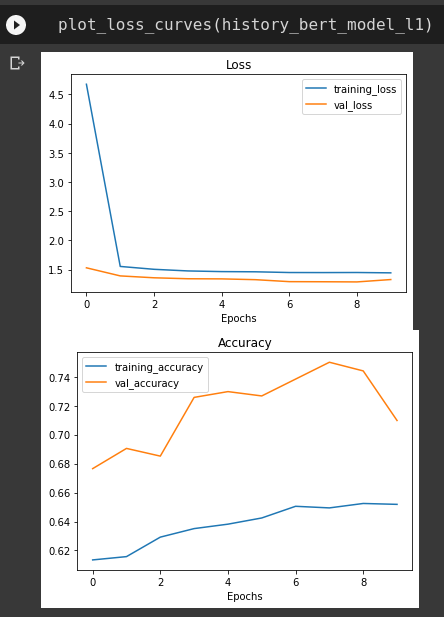


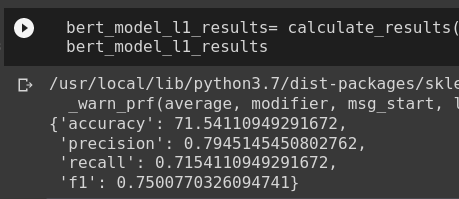



In [73]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer='l1')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer='l1')(x)

bert_model_l1= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_l1")

In [74]:
bert_model_l1.summary()

Model: "bert_expert_pubmed_layer_l1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_word_ids':   0          ['input_sentences[0][0]']        
 sLayer)                        (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                

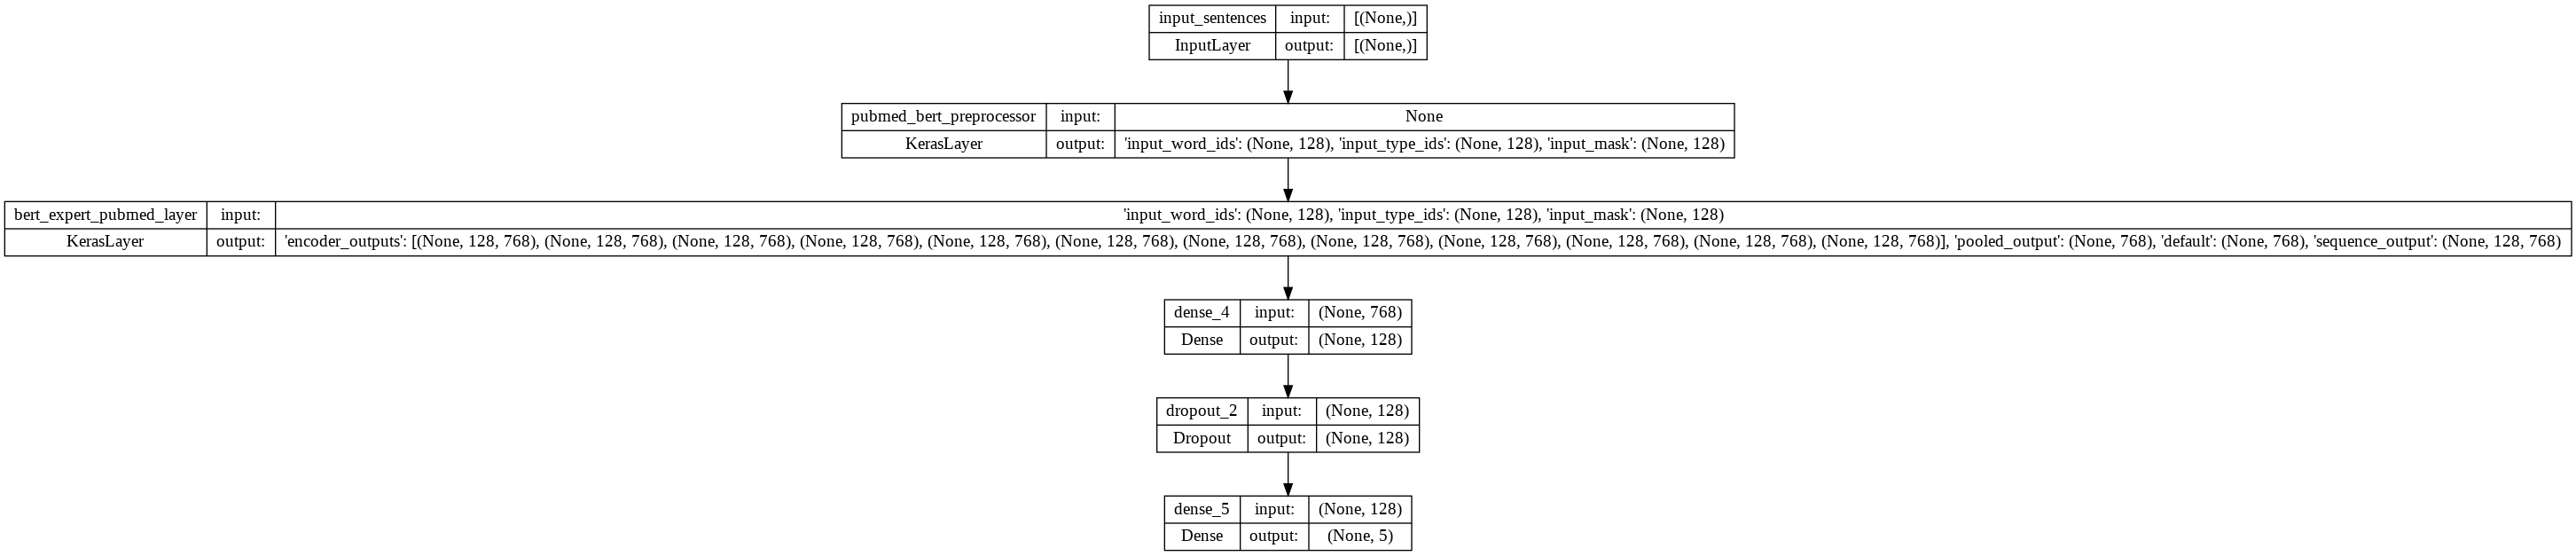

In [75]:
plot_model(bert_model_l1, show_shapes=True)

### Callbacks for Bert Model using `L1 regularizer`

In [76]:
model_checkpoint_path= 'checkpoints_bert_model_l1'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_l1")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_l1/20220904-045938


In [77]:
bert_model_l1.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model_l1= bert_model_l1.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 4.6738 - accuracy: 0.6135
Epoch 1: val_accuracy improved from -inf to 0.67653, saving model to checkpoints_bert_model_l1
562/562 [==============================] - 229s 403ms/step - loss: 4.6738 - accuracy: 0.6135 - val_loss: 1.5305 - val_accuracy: 0.6765 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.6158
Epoch 2: val_accuracy improved from 0.67653 to 0.69049, saving model to checkpoints_bert_model_l1
562/562 [==============================] - 223s 398ms/step - loss: 1.5540 - accuracy: 0.6158 - val_loss: 1.3919 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.5048 - accuracy: 0.6292
Epoch 3: val_accuracy did not improve from 0.69049
562/562 [==============================] - 221s 393ms/step - loss: 1.5048 - accuracy: 0.6292 - val_loss: 1.3596 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 4/10
562/562 [====

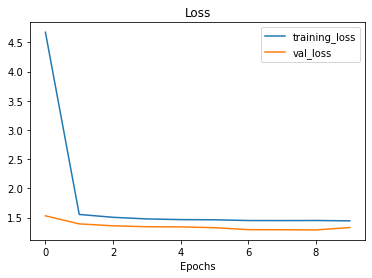

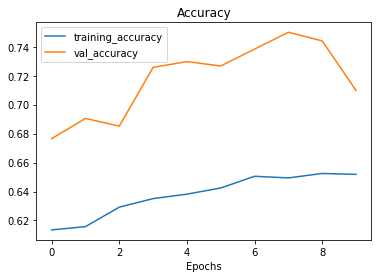

In [78]:
plot_loss_curves(history_bert_model_l1)

In [79]:
bert_model_l1_pred_probs= bert_model_l1.predict(val_sen_ds)
bert_model_l1_preds= tf.argmax(bert_model_l1_pred_probs, axis=1)
bert_model_l1_preds

945/945 [==============================] - 301s 318ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 0, ..., 4, 1, 1])>

In [80]:
bert_model_l1_results= calculate_results(bert_model_l1_preds, val_labels_encoder)
bert_model_l1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 71.54110949291672,
 'precision': 0.7945145450802762,
 'recall': 0.7154110949291672,
 'f1': 0.7500770326094741}

## Bert Expert Pubmed Model with trainable=False, using `L2 regularizer`

### Default Value

>In this case, the default value used is `l2=0.01`.

### Results

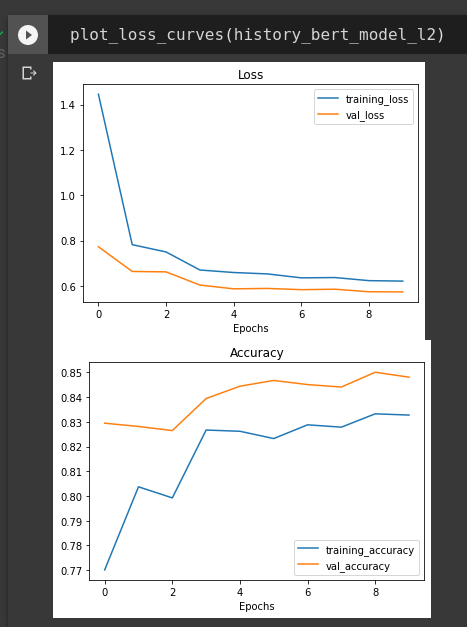


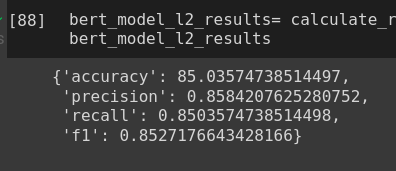



In [81]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer= 'l2')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer= 'l2')(x)

bert_model_l2= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_l2")

In [82]:
bert_model_l2.summary()

Model: "bert_expert_pubmed_layer_l2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_word_ids':   0          ['input_sentences[0][0]']        
 sLayer)                        (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                

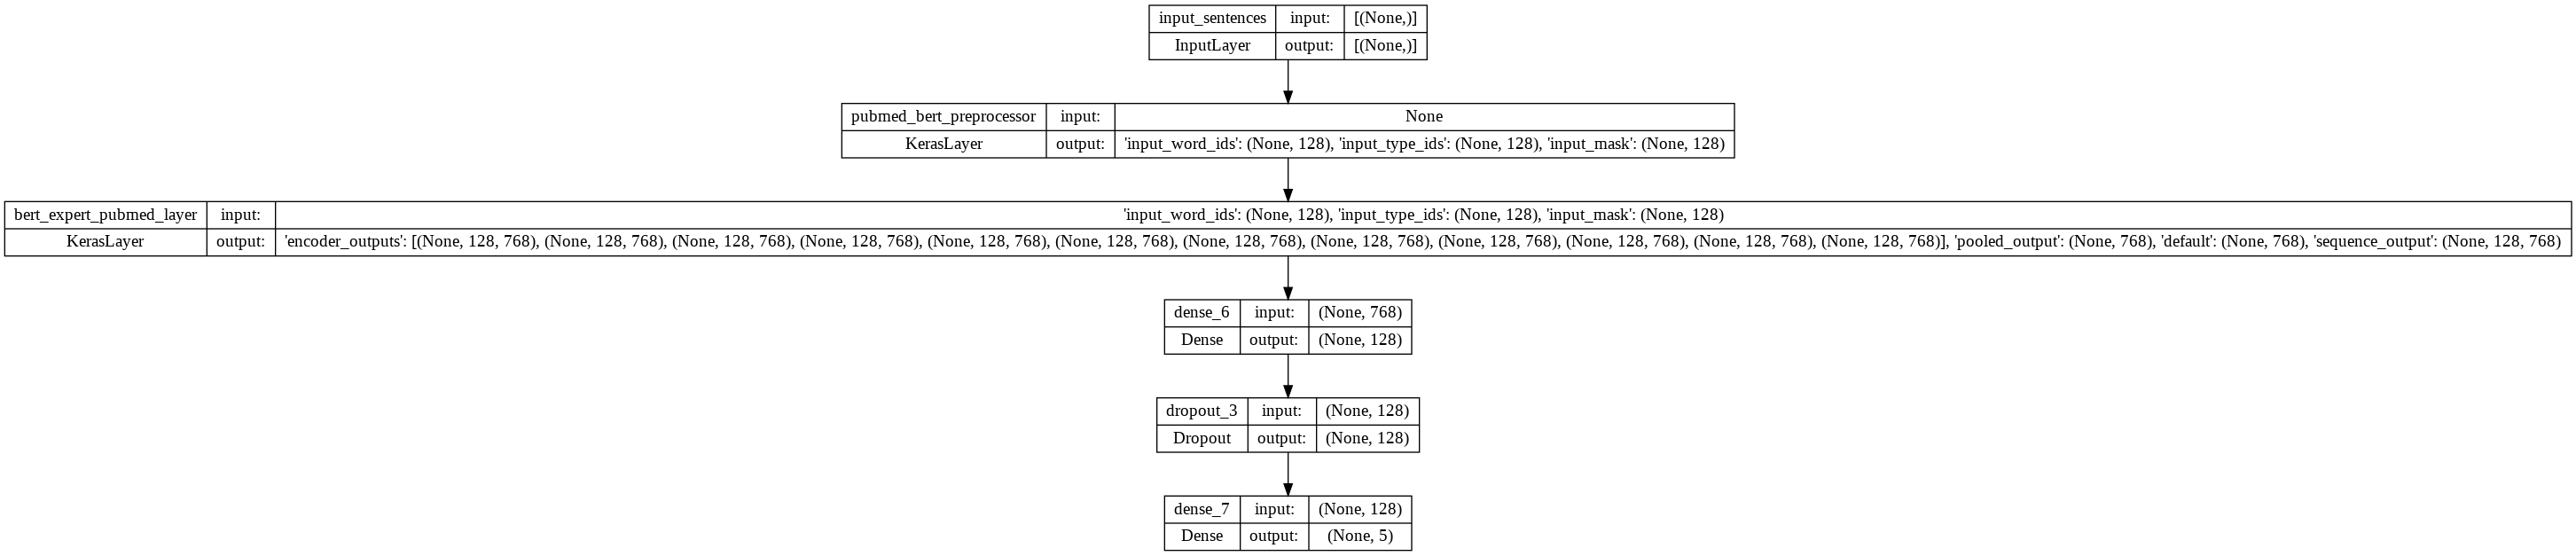

In [83]:
plot_model(bert_model_l2, show_shapes=True)

### Callbacks for Bert Model using `L2 regularizer`

In [84]:
model_checkpoint_path= 'checkpoints_bert_model_l2'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_l2")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_l2/20220904-054207


In [85]:
bert_model_l2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model_l2= bert_model_l2.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.4458 - accuracy: 0.7701
Epoch 1: val_accuracy improved from -inf to 0.82945, saving model to checkpoints_bert_model_l2
562/562 [==============================] - 226s 398ms/step - loss: 1.4458 - accuracy: 0.7701 - val_loss: 0.7729 - val_accuracy: 0.8295 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.7822 - accuracy: 0.8037
Epoch 2: val_accuracy did not improve from 0.82945
562/562 [==============================] - 221s 393ms/step - loss: 0.7822 - accuracy: 0.8037 - val_loss: 0.6639 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.7992
Epoch 3: val_accuracy did not improve from 0.82945

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
562/562 [==============================] - 221s 394ms/step - loss: 0.7499 - accuracy: 0.7992 - val_loss: 0.6621 - val_accuracy: 0.8265 - lr: 

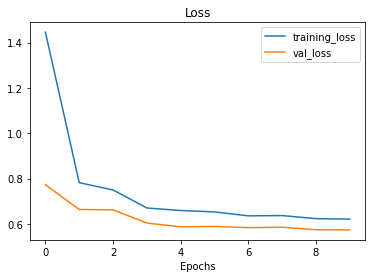

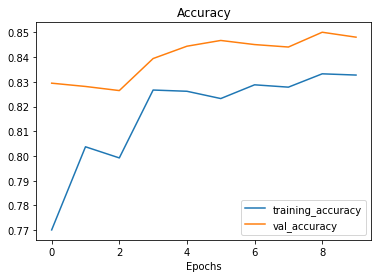

In [86]:
plot_loss_curves(history_bert_model_l2)

In [87]:
bert_model_l2_pred_probs= bert_model_l2.predict(val_sen_ds)
bert_model_l2_preds= tf.argmax(bert_model_l2_pred_probs, axis=1)
bert_model_l2_preds

945/945 [==============================] - 302s 319ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [88]:
bert_model_l2_results= calculate_results(bert_model_l2_preds, val_labels_encoder)
bert_model_l2_results

{'accuracy': 85.03574738514497,
 'precision': 0.8584207625280752,
 'recall': 0.8503574738514498,
 'f1': 0.8527176643428166}

## Bert Expert Pubmed Model with trainable=False, using `L1 and L2 regularizer` both

### Default value 

> In this case, the default values used are `l1=0.01` and `l2=0.01`.

### Results

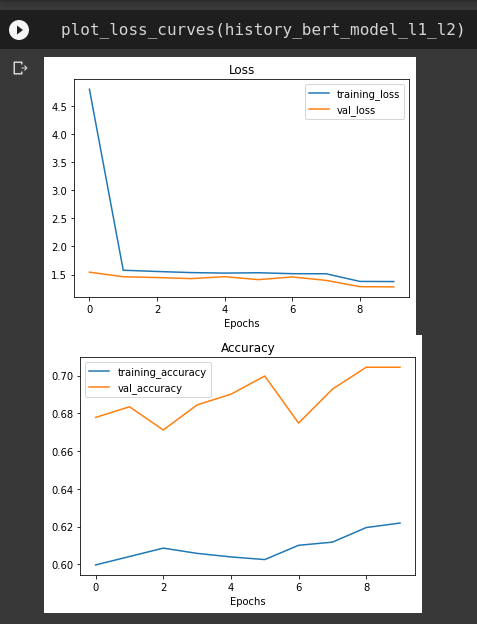

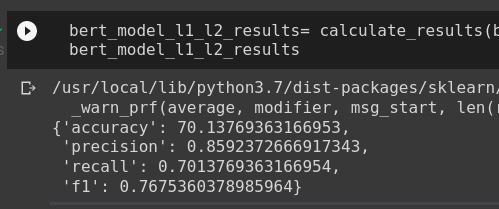



In [89]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer= 'l1_l2')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer= 'l1_l2')(x)

bert_model_l1_l2= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_l1_l2")

In [90]:
bert_model_l1_l2.summary()

Model: "bert_expert_pubmed_layer_l1_l2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_word_ids':   0          ['input_sentences[0][0]']        
 sLayer)                        (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                             

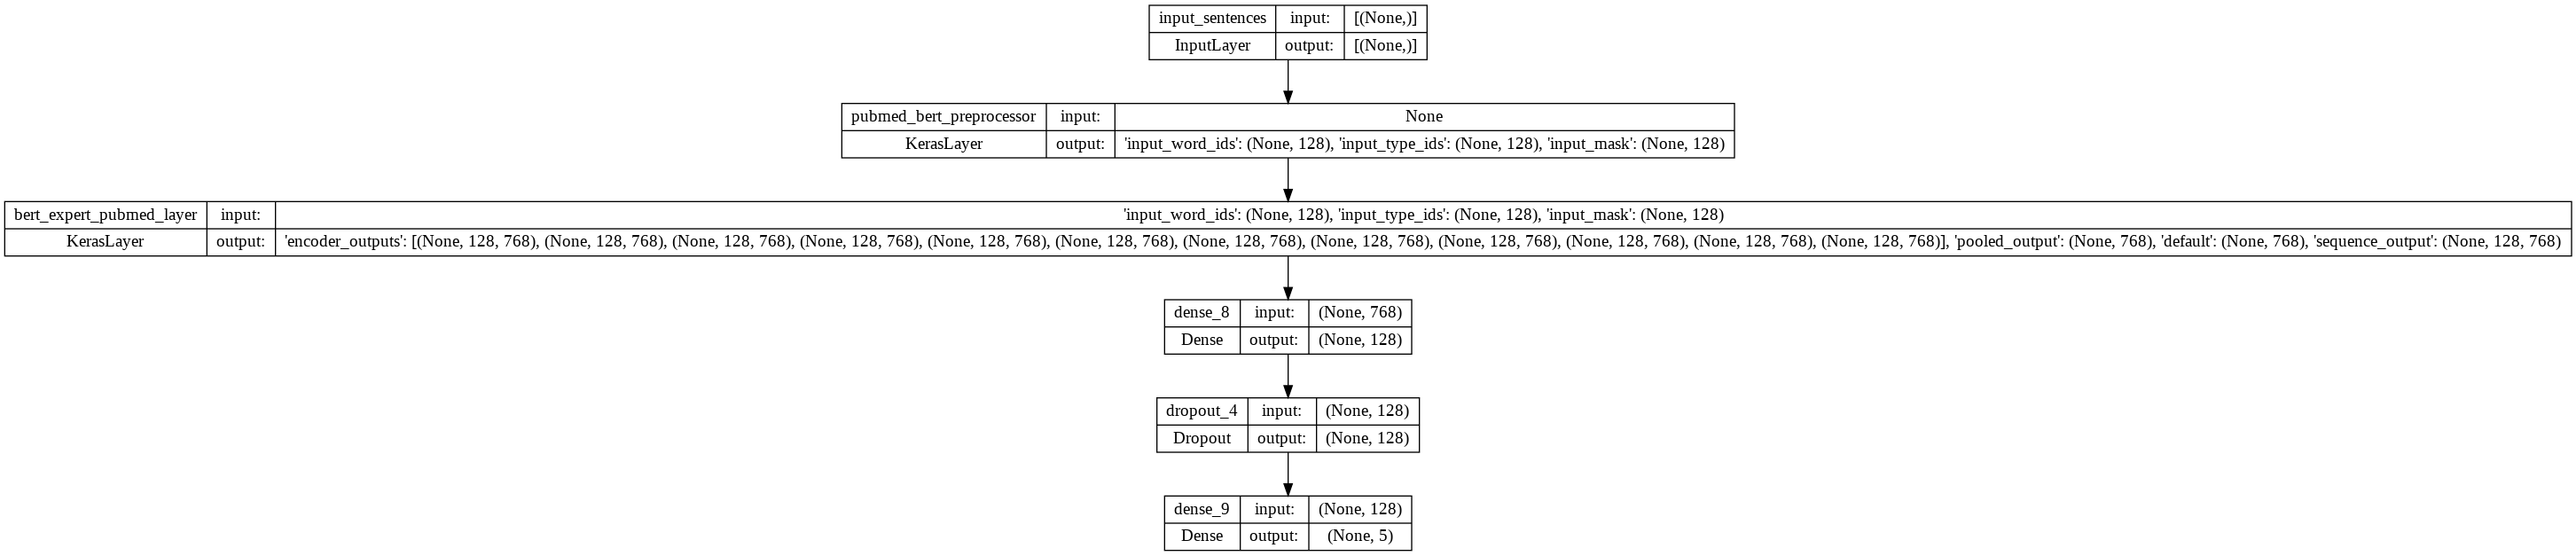

In [91]:
plot_model(bert_model_l1_l2, show_shapes=True)

### Callbacks for Bert Model using `L1 and L2 regularizer`

In [92]:
model_checkpoint_path= 'checkpoints_bert_model_l1_l2'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_l1_l2")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_l1_l2/20220904-062334


In [93]:
bert_model_l1_l2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model_l1_l2= bert_model_l1_l2.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 4.7947 - accuracy: 0.5997
Epoch 1: val_accuracy improved from -inf to 0.67786, saving model to checkpoints_bert_model_l1_l2
562/562 [==============================] - 226s 397ms/step - loss: 4.7947 - accuracy: 0.5997 - val_loss: 1.5423 - val_accuracy: 0.6779 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 1.5765 - accuracy: 0.6041
Epoch 2: val_accuracy improved from 0.67786 to 0.68351, saving model to checkpoints_bert_model_l1_l2
562/562 [==============================] - 224s 398ms/step - loss: 1.5765 - accuracy: 0.6041 - val_loss: 1.4606 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.5543 - accuracy: 0.6086
Epoch 3: val_accuracy did not improve from 0.68351
562/562 [==============================] - 222s 394ms/step - loss: 1.5543 - accuracy: 0.6086 - val_loss: 1.4464 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 4/10
562/562

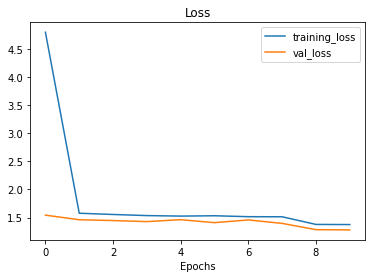

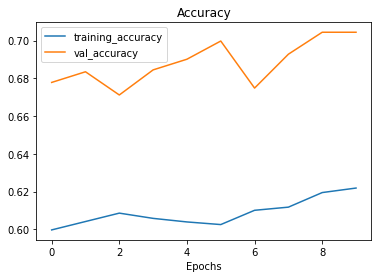

In [94]:
plot_loss_curves(history_bert_model_l1_l2)

In [95]:
bert_model_l1_l2_pred_probs= bert_model_l1_l2.predict(val_sen_ds)
bert_model_l1_l2_preds= tf.argmax(bert_model_l1_l2_pred_probs, axis=1)
bert_model_l1_l2_preds

945/945 [==============================] - 302s 319ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 1, 1])>

In [96]:
bert_model_l1_l2_results= calculate_results(bert_model_l1_l2_preds, val_labels_encoder)
bert_model_l1_l2_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 70.13769363166953,
 'precision': 0.8592372666917343,
 'recall': 0.7013769363166954,
 'f1': 0.7675360378985964}

## Conclusion with the different `regularizers`

In [97]:
bert_model_results

{'accuracy': 86.35972461273667,
 'precision': 0.8711757728385985,
 'recall': 0.8635972461273667,
 'f1': 0.8659249750160055}

In [98]:
bert_model_l1_results

{'accuracy': 71.54110949291672,
 'precision': 0.7945145450802762,
 'recall': 0.7154110949291672,
 'f1': 0.7500770326094741}

In [99]:
bert_model_l2_results

{'accuracy': 85.03574738514497,
 'precision': 0.8584207625280752,
 'recall': 0.8503574738514498,
 'f1': 0.8527176643428166}

In [100]:
bert_model_l1_l2_results

{'accuracy': 70.13769363166953,
 'precision': 0.8592372666917343,
 'recall': 0.7013769363166954,
 'f1': 0.7675360378985964}

## Bert Expert Pubmed Model using `SGD()` with `trainable=False`


### Before

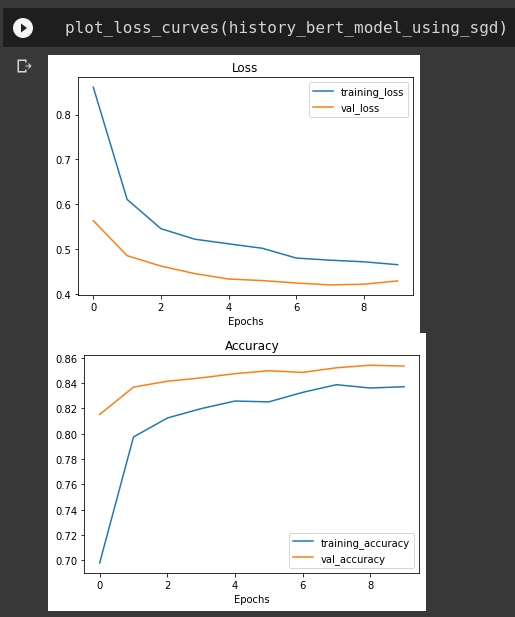

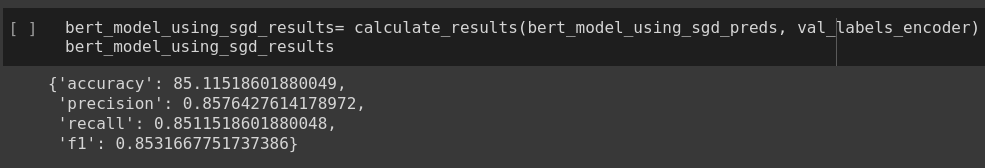


### After

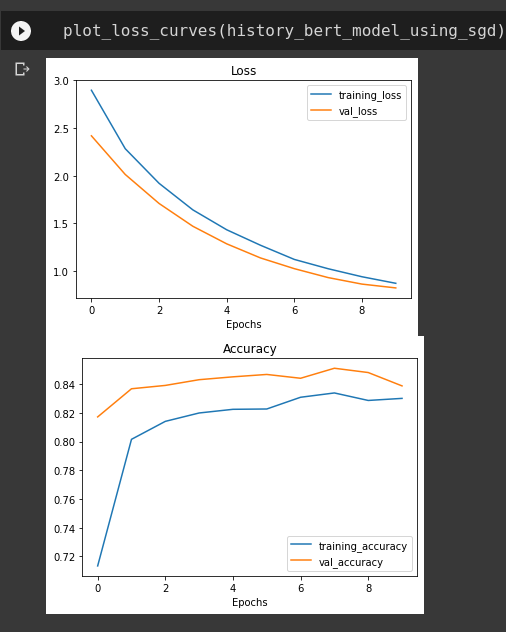


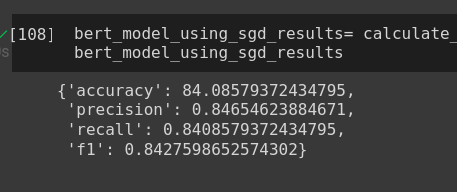


In [101]:
model_checkpoint_path= 'checkpoints_bert_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_using_sgd/20220904-070559


In [102]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer='l2')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

bert_model_using_sgd= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_using_sgd")

In [103]:
bert_model_using_sgd.summary()

Model: "bert_expert_pubmed_layer_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_word_ids':   0          ['input_sentences[0][0]']        
 sLayer)                        (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                         

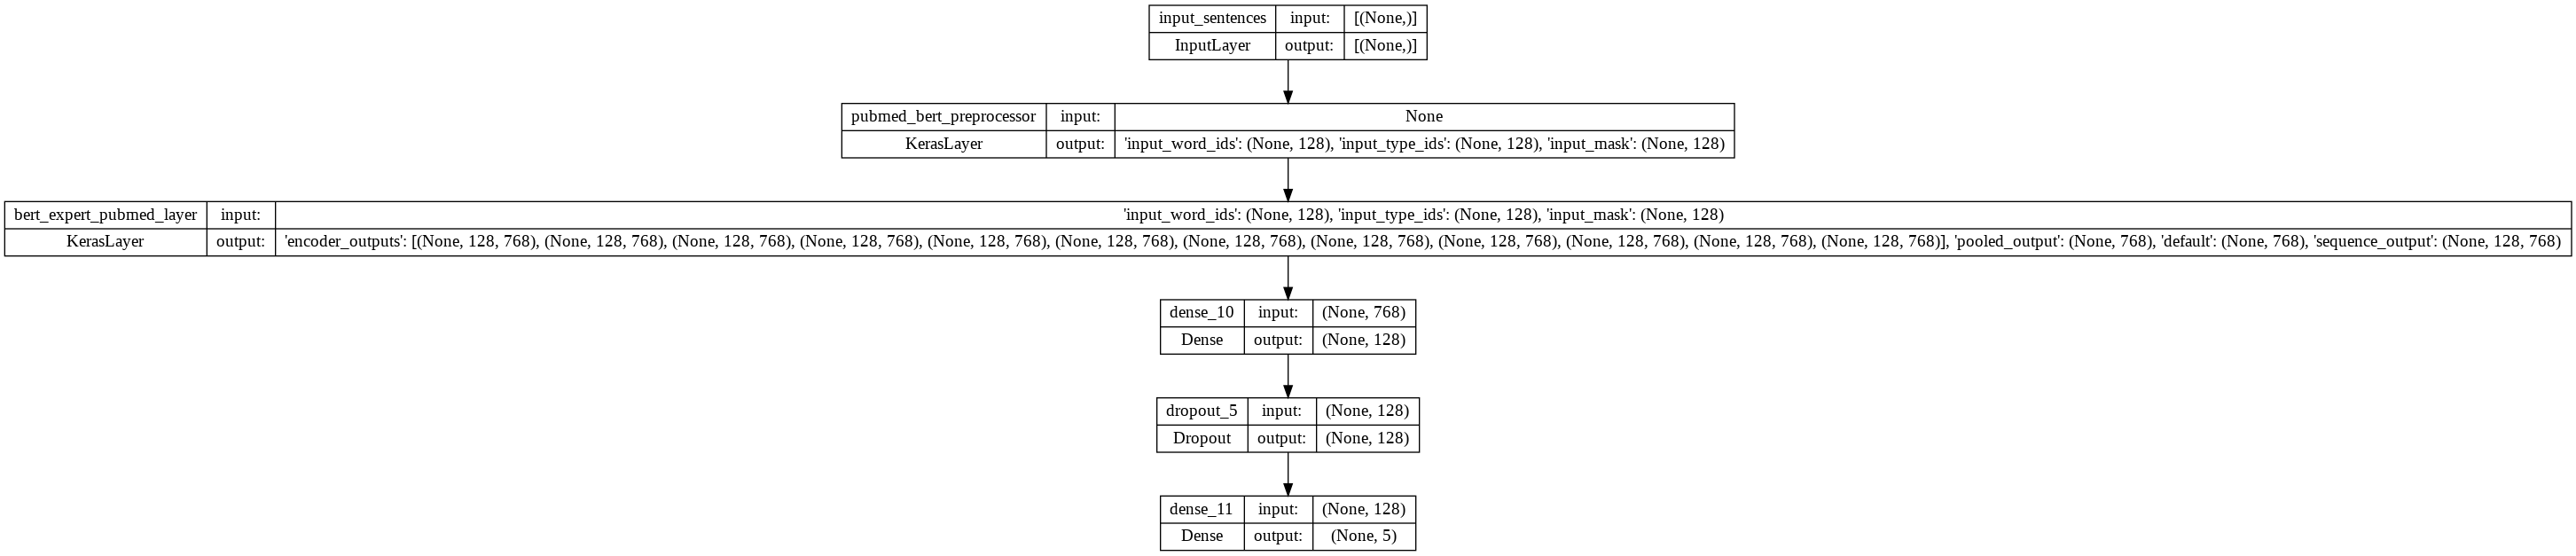

In [104]:
plot_model(bert_model_using_sgd, show_shapes=True)

In [105]:
bert_model_using_sgd.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

history_bert_model_using_sgd= bert_model_using_sgd.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 2.8973 - accuracy: 0.7134
Epoch 1: val_accuracy improved from -inf to 0.81715, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 227s 399ms/step - loss: 2.8973 - accuracy: 0.7134 - val_loss: 2.4192 - val_accuracy: 0.8172 - lr: 0.0100
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 2.2840 - accuracy: 0.8015
Epoch 2: val_accuracy improved from 0.81715 to 0.83677, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 212s 378ms/step - loss: 2.2840 - accuracy: 0.8015 - val_loss: 2.0138 - val_accuracy: 0.8368 - lr: 0.0100
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.9210 - accuracy: 0.8141
Epoch 3: val_accuracy improved from 0.83677 to 0.83910, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 212s 377ms/step - loss: 1.9210 - accuracy: 0.8141 - val_loss:

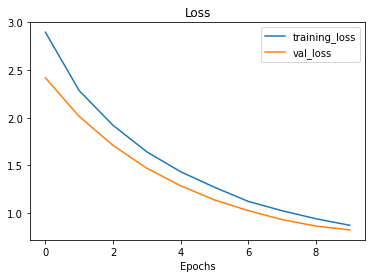

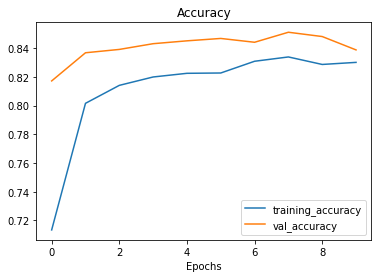

In [106]:
plot_loss_curves(history_bert_model_using_sgd)

In [107]:
bert_model_using_sgd_pred_probs= bert_model_using_sgd.predict(val_sen_ds)
bert_model_using_sgd_preds= tf.argmax(bert_model_using_sgd_pred_probs, axis=1)
bert_model_using_sgd_preds

945/945 [==============================] - 302s 320ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [108]:
bert_model_using_sgd_results= calculate_results(bert_model_using_sgd_preds, val_labels_encoder)
bert_model_using_sgd_results

{'accuracy': 84.08579372434795,
 'precision': 0.84654623884671,
 'recall': 0.8408579372434795,
 'f1': 0.8427598652574302}

## Bert Expert Pubmed Model with `trainable=True` on both of the `preprocessing` as well as the `bert_pubmed_layer`

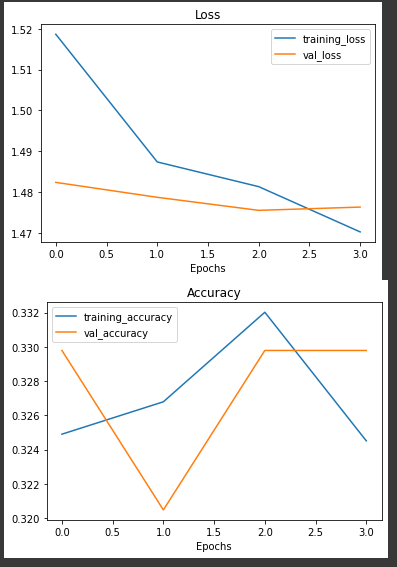

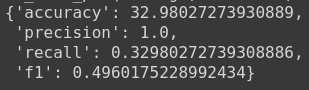

### When Trying to create a model

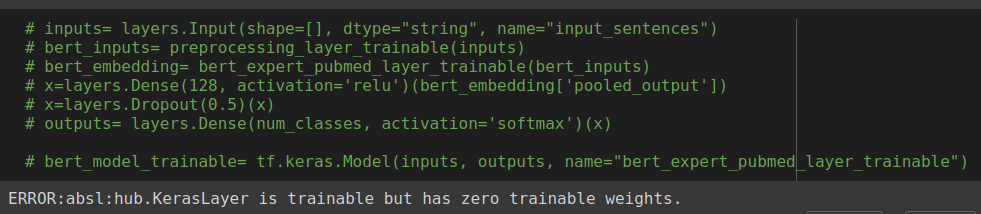

In [ ]:
# preprocessing_layer_trainable = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = True , name = 'pubmed_bert_preprocessor_trainable')
# preprocessing_layer_trainable

In [ ]:
# bert_expert_pubmed_layer_trainable= hub.KerasLayer(model_url, trainable=True, name="bert_expert_pubmed_layer_trainable")
# bert_expert_pubmed_layer_trainable

In [ ]:
# inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
# bert_inputs= preprocessing_layer_trainable(inputs)
# bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
# x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
# x=layers.Dropout(0.5)(x)
# outputs= layers.Dense(num_classes, activation='softmax')(x)

# bert_model_trainable= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable")

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [ ]:
# bert_model_trainable.summary()

Model: "bert_expert_pubmed_layer_trainable"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor_train  {'input_type_ids':   0          ['input_sentences[0][0]']        
 able (KerasLayer)              (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                     

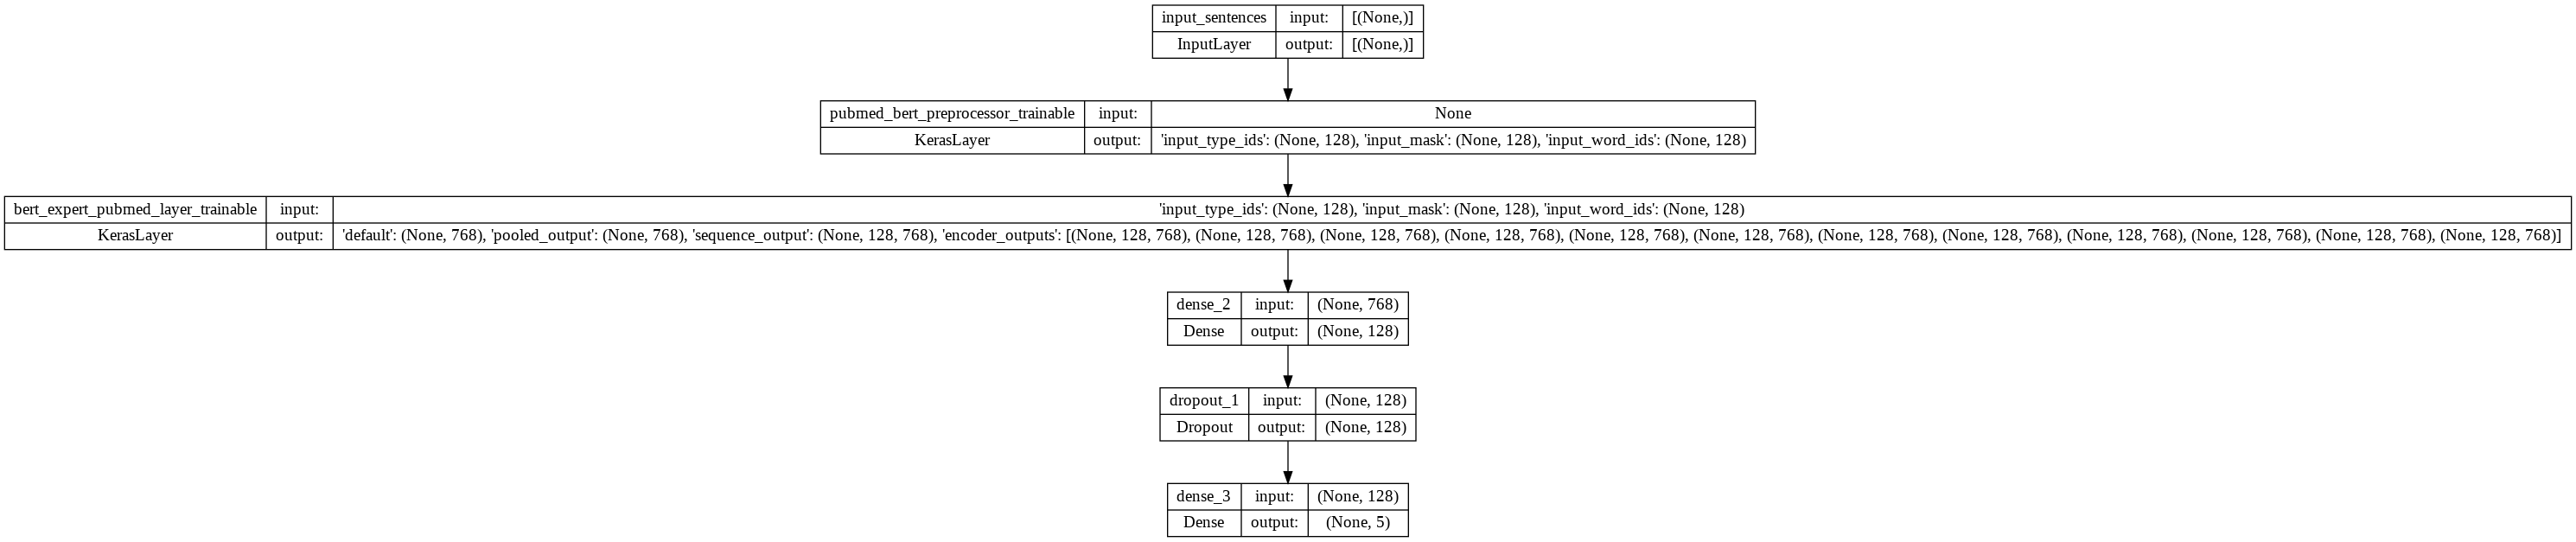

In [ ]:
# plot_model(bert_model_trainable, show_shapes=True)

### Callbacks for Bert model with `trainable=True`

In [ ]:
# model_checkpoint_path= 'checkpoints_bert_model_trainable'
# check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

# dir_name= 'tensorboard'
# tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable")

# early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

# reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_trainable/20220903-054505


In [ ]:
# bert_model_trainable.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

# history_bert_model_trainable= bert_model_trainable.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.5186 - accuracy: 0.3249
Epoch 1: val_accuracy improved from -inf to 0.32979, saving model to checkpoints_bert_model_trainable
562/562 [==============================] - 539s 935ms/step - loss: 1.5186 - accuracy: 0.3249 - val_loss: 1.4823 - val_accuracy: 0.3298 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 1.4874 - accuracy: 0.3268
Epoch 2: val_accuracy did not improve from 0.32979
562/562 [==============================] - 506s 900ms/step - loss: 1.4874 - accuracy: 0.3268 - val_loss: 1.4787 - val_accuracy: 0.3205 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.4813 - accuracy: 0.3320
Epoch 3: val_accuracy did not improve from 0.32979

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
562/562 [==============================] - 504s 897ms/step - loss: 1.4813 - accuracy: 0.3320 - val_loss: 1.4755 - val_accuracy: 0.3298

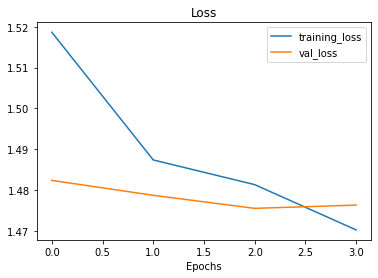

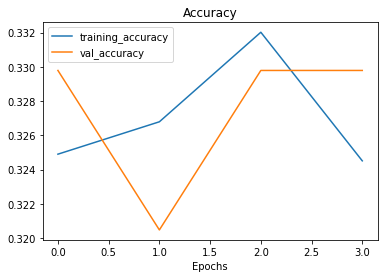

In [ ]:
# plot_loss_curves(history_bert_model_trainable)

In [ ]:
# bert_model_trainable_pred_probs= bert_model_trainable.predict(val_sen_ds)
# bert_model_trainable_preds= tf.argmax(bert_model_trainable_pred_probs, axis=1)
# bert_model_trainable_preds

945/945 [==============================] - 296s 313ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 2])>

In [ ]:
# bert_model_trainable_results= calculate_results(bert_model_trainable_preds, val_labels_encoder)
# bert_model_trainable_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 32.98027273930889,
 'precision': 1.0,
 'recall': 0.32980272739308886,
 'f1': 0.4960175228992434}

## Bert Expert Pubmed Model with `trainable=True` only on the `Bert Pubmed layer`

* Reference Link -> https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

> It is talking about the `preprocessing layer` and it doesn't have any trainable parameters.

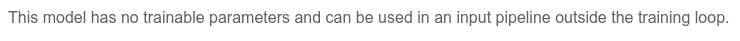


### Conclusion

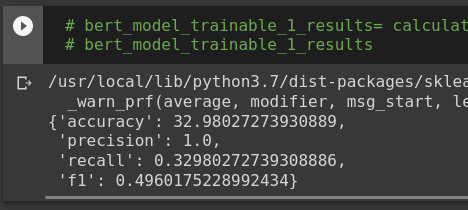


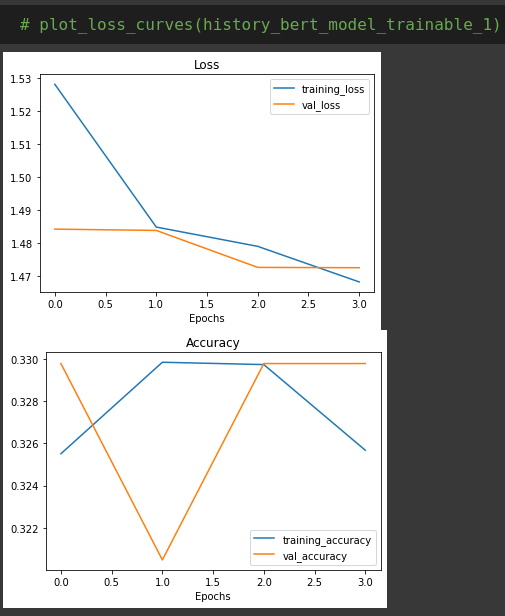

In [ ]:
# preprocessing_layer_trainable = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = False , name = 'pubmed_bert_preprocessor_trainable')
# preprocessing_layer_trainable

In [ ]:
# bert_expert_pubmed_layer_trainable= hub.KerasLayer(model_url, trainable=True, name="bert_expert_pubmed_layer_trainable")
# bert_expert_pubmed_layer_trainable

In [ ]:
# inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
# bert_inputs= preprocessing_layer_trainable(inputs)
# bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
# x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
# x=layers.Dropout(0.5)(x)
# outputs= layers.Dense(num_classes, activation='softmax')(x)

# bert_model_trainable_1= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable_1")

In [ ]:
bert_model_trainable_1.summary()

Model: "bert_expert_pubmed_layer_trainable_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor_train  {'input_mask': (Non  0          ['input_sentences[0][0]']        
 able (KerasLayer)              e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                   

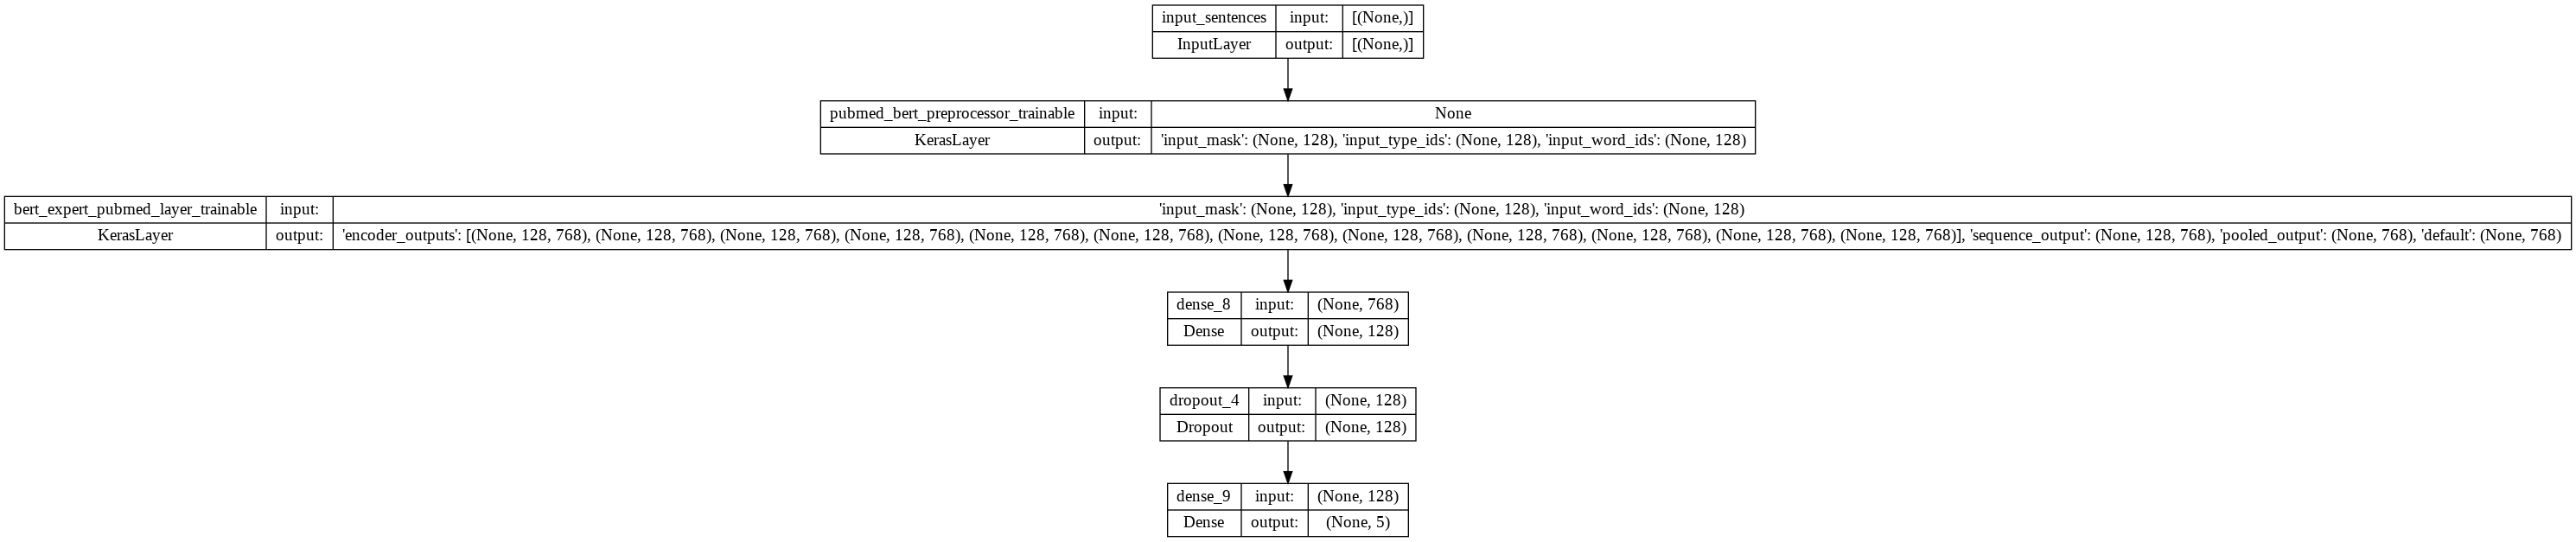

In [ ]:
# plot_model(bert_model_trainable_1, show_shapes=True)

In [ ]:
# model_checkpoint_path= 'checkpoints_bert_model_trainable_1'
# check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

# dir_name= 'tensorboard'
# tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable_1")

# early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

# reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_trainable_1/20220903-062745


In [ ]:
# bert_model_trainable_1.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

# history_bert_model_trainable_1= bert_model_trainable_1.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.5280 - accuracy: 0.3255
Epoch 1: val_accuracy improved from -inf to 0.32979, saving model to checkpoints_bert_model_trainable_1
562/562 [==============================] - 527s 913ms/step - loss: 1.5280 - accuracy: 0.3255 - val_loss: 1.4843 - val_accuracy: 0.3298 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 1.4849 - accuracy: 0.3298
Epoch 2: val_accuracy did not improve from 0.32979
562/562 [==============================] - 505s 899ms/step - loss: 1.4849 - accuracy: 0.3298 - val_loss: 1.4839 - val_accuracy: 0.3205 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.4791 - accuracy: 0.3297
Epoch 3: val_accuracy did not improve from 0.32979

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
562/562 [==============================] - 504s 896ms/step - loss: 1.4791 - accuracy: 0.3297 - val_loss: 1.4727 - val_accuracy: 0.32

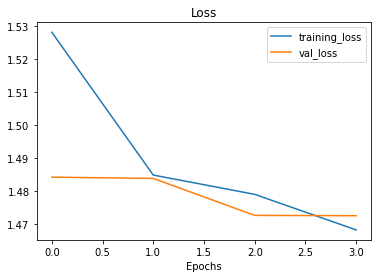

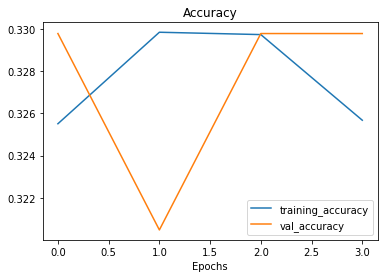

In [ ]:
# plot_loss_curves(history_bert_model_trainable_1)

In [ ]:
# bert_model_trainable_1_pred_probs= bert_model_trainable_1.predict(val_sen_ds)
# bert_model_trainable_1_preds= tf.argmax(bert_model_trainable_1_pred_probs, axis=1)
# bert_model_trainable_1_preds

945/945 [==============================] - 294s 311ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 2])>

In [ ]:
# bert_model_trainable_1_results= calculate_results(bert_model_trainable_1_preds, val_labels_encoder)
# bert_model_trainable_1_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 32.98027273930889,
 'precision': 1.0,
 'recall': 0.32980272739308886,
 'f1': 0.4960175228992434}

## Bert Expert Pubmed Model with `trainable=True` only on the `preprocessing layer`

* Reference Link -> https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

> It is talking about the `preprocessing layer` and it doesn't have any trainable parameters.

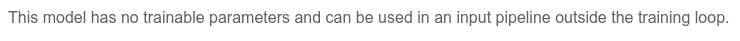

### `Conclusion`

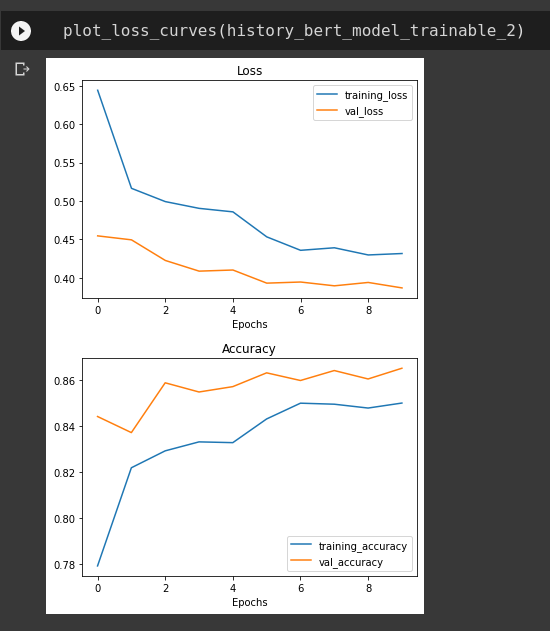


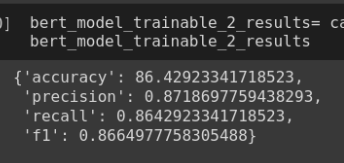


### After 

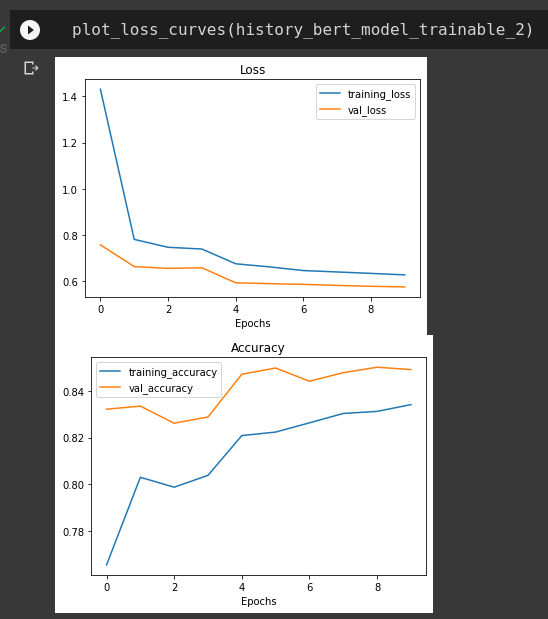

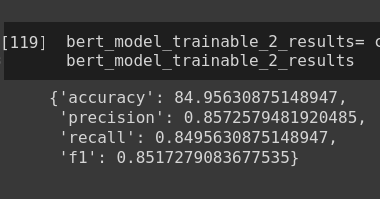

In [109]:
preprocessing_layer_trainable = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = True , name = 'pubmed_bert_preprocessor_trainable')
preprocessing_layer_trainable

In [110]:
bert_expert_pubmed_layer_trainable= hub.KerasLayer(model_url, trainable=False, name="bert_expert_pubmed_layer_trainable")
bert_expert_pubmed_layer_trainable

In [111]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer_trainable(inputs)
bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer='l2')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

bert_model_trainable_2= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable_2")

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [112]:
bert_model_trainable_2.summary()

Model: "bert_expert_pubmed_layer_trainable_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor_train  {'input_mask': (Non  0          ['input_sentences[0][0]']        
 able (KerasLayer)              e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                   

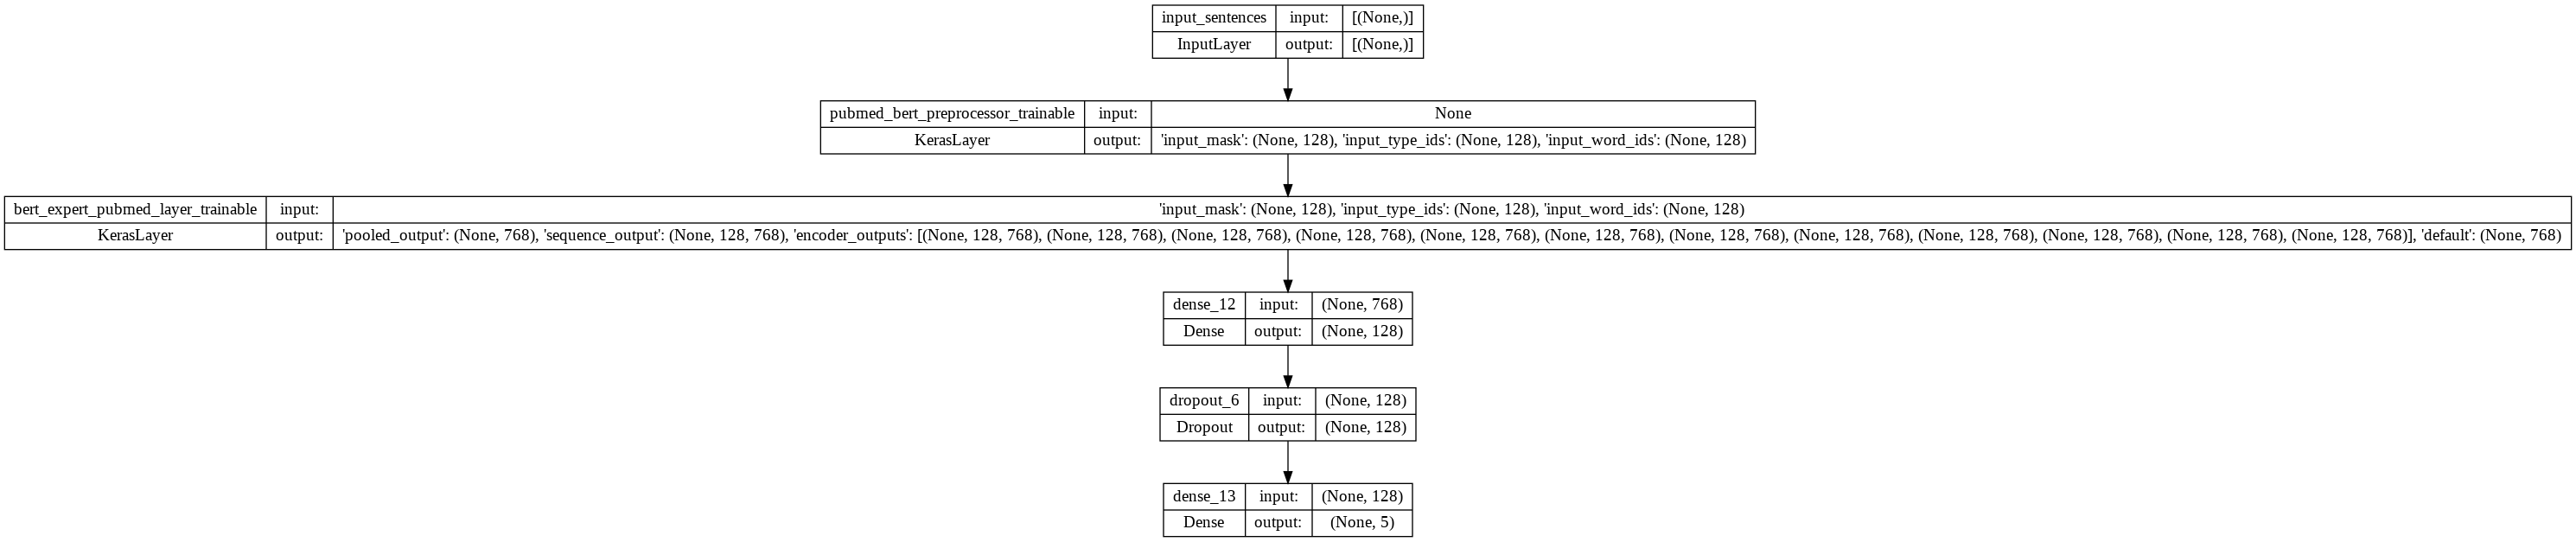

In [114]:
plot_model(bert_model_trainable_2, show_shapes=True)

In [115]:
model_checkpoint_path= 'checkpoints_bert_model_trainable_2'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable_2")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_trainable_2/20220904-074841


In [116]:
bert_model_trainable_2.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model_trainable_2= bert_model_trainable_2.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.7655
Epoch 1: val_accuracy improved from -inf to 0.83211, saving model to checkpoints_bert_model_trainable_2
562/562 [==============================] - 218s 372ms/step - loss: 1.4314 - accuracy: 0.7655 - val_loss: 0.7561 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.7801 - accuracy: 0.8030
Epoch 2: val_accuracy improved from 0.83211 to 0.83344, saving model to checkpoints_bert_model_trainable_2
562/562 [==============================] - 222s 396ms/step - loss: 0.7801 - accuracy: 0.8030 - val_loss: 0.6620 - val_accuracy: 0.8334 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7988
Epoch 3: val_accuracy did not improve from 0.83344
562/562 [==============================] - 220s 392ms/step - loss: 0.7457 - accuracy: 0.7988 - val_loss: 0.6541 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 

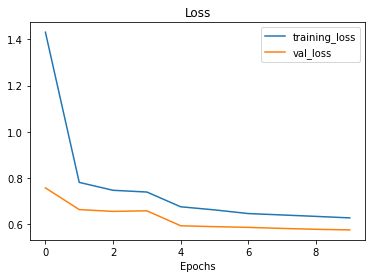

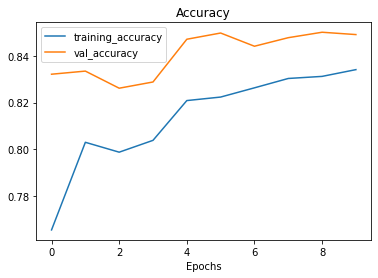

In [117]:
plot_loss_curves(history_bert_model_trainable_2)

In [118]:
bert_model_trainable_2_pred_probs= bert_model_trainable_2.predict(val_sen_ds)
bert_model_trainable_2_preds= tf.argmax(bert_model_trainable_2_pred_probs, axis=1)
bert_model_trainable_2_preds

945/945 [==============================] - 302s 319ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 1, 1])>

In [119]:
bert_model_trainable_2_results= calculate_results(bert_model_trainable_2_preds, val_labels_encoder)
bert_model_trainable_2_results

{'accuracy': 84.95630875148947,
 'precision': 0.8572579481920485,
 'recall': 0.8495630875148947,
 'f1': 0.8517279083677535}

## Bert Expert Pubmed Model using `SGD()` with `trainable=True`

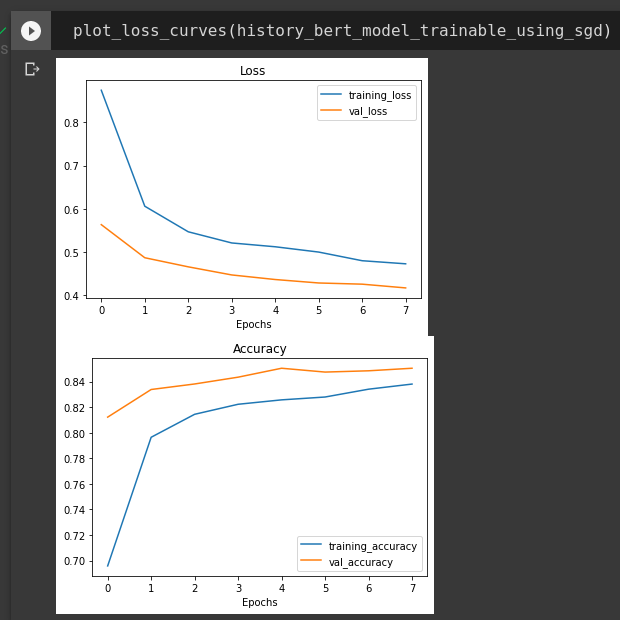

In [120]:
preprocessing_layer_trainable = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = True , name = 'pubmed_bert_preprocessor_trainable')
preprocessing_layer_trainable

In [121]:
bert_expert_pubmed_layer_trainable= hub.KerasLayer(model_url, trainable=False, name="bert_expert_pubmed_layer_trainable")
bert_expert_pubmed_layer_trainable

In [122]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer_trainable(inputs)
bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
x=layers.Dense(128, activation='relu', kernel_regularizer='l2')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

bert_model_trainable_using_sgd= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable_using_sgd")

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [123]:
bert_model_trainable_using_sgd.summary()

Model: "bert_expert_pubmed_layer_trainable_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor_train  {'input_word_ids':   0          ['input_sentences[0][0]']        
 able (KerasLayer)              (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}           

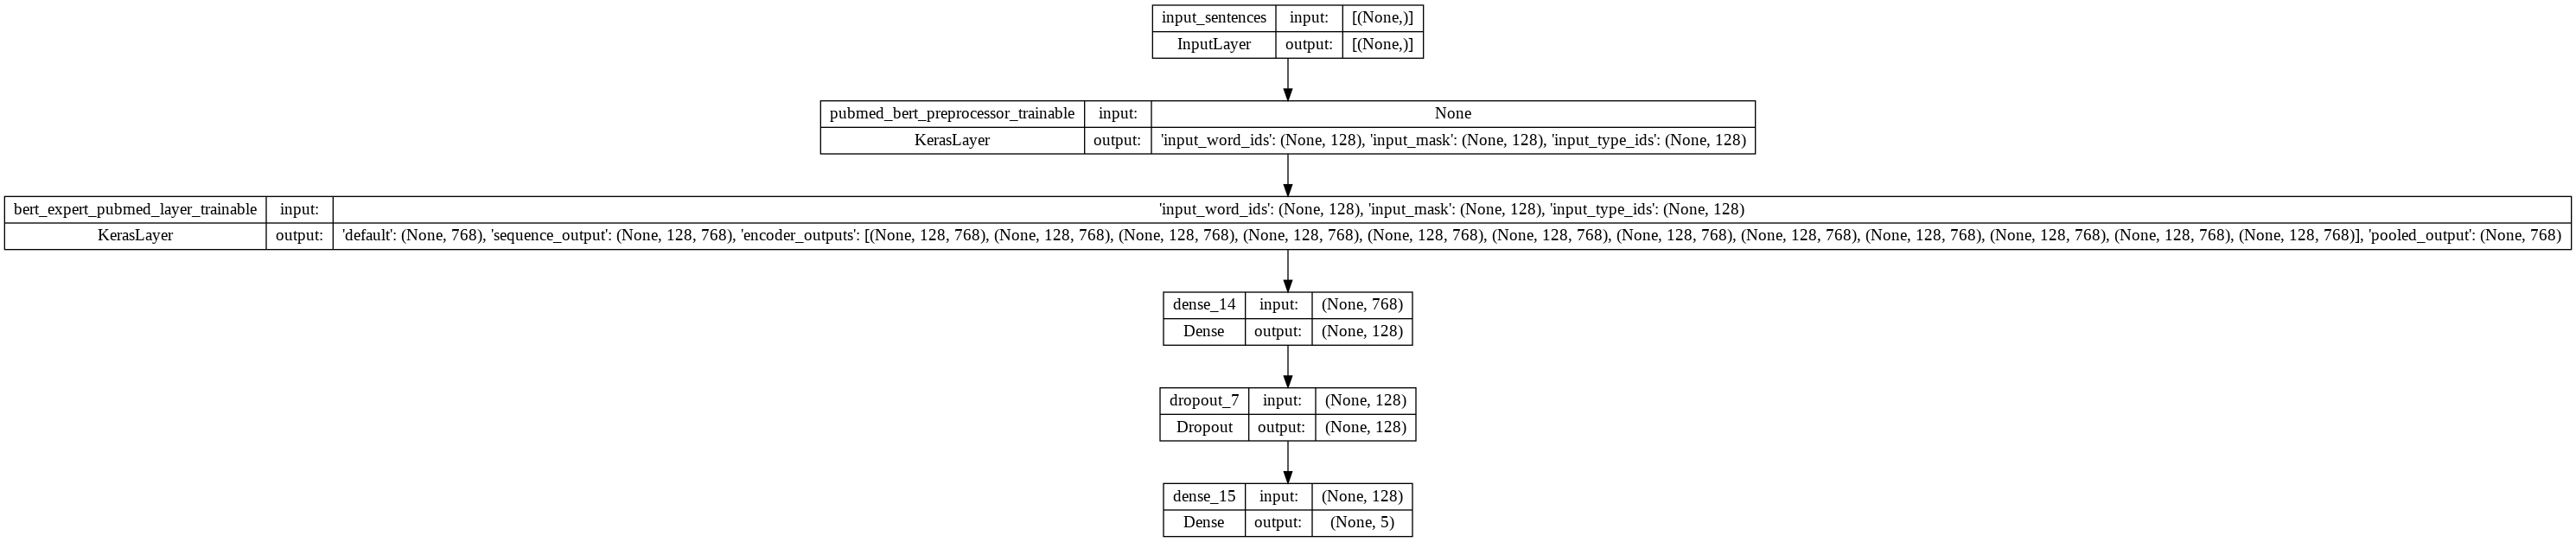

In [124]:
plot_model(bert_model_trainable_using_sgd, show_shapes=True)

### Callbacks for Bert model using `SGD()` and `trainable=True`

In [125]:
model_checkpoint_path= 'checkpoints_bert_model_trainable_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_trainable_using_sgd/20220904-083025


In [ ]:
bert_model_trainable_using_sgd.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

history_bert_model_trainable_using_sgd= bert_model_trainable_using_sgd.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 2.9267 - accuracy: 0.6976
Epoch 1: val_accuracy improved from -inf to 0.81017, saving model to checkpoints_bert_model_trainable_using_sgd
562/562 [==============================] - 232s 398ms/step - loss: 2.9267 - accuracy: 0.6976 - val_loss: 2.4381 - val_accuracy: 0.8102 - lr: 0.0100
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 2.2924 - accuracy: 0.7949
Epoch 2: val_accuracy improved from 0.81017 to 0.83112, saving model to checkpoints_bert_model_trainable_using_sgd
562/562 [==============================] - 212s 376ms/step - loss: 2.2924 - accuracy: 0.7949 - val_loss: 2.0174 - val_accuracy: 0.8311 - lr: 0.0100
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 1.9312 - accuracy: 0.8122
Epoch 3: val_accuracy improved from 0.83112 to 0.83378, saving model to checkpoints_bert_model_trainable_using_sgd
562/562 [==============================] - 211s 376ms/step - loss: 1.9312 

In [ ]:
plot_loss_curves(history_bert_model_trainable_using_sgd)

In [ ]:
bert_model_trainable_using_sgd_pred_probs= bert_model_trainable_using_sgd.predict(val_sen_ds)
bert_model_trainable_using_sgd_preds= tf.argmax(bert_model_trainable_using_sgd_pred_probs, axis=1)
bert_model_trainable_using_sgd_preds

In [ ]:
bert_model_trainable_using_sgd_results= calculate_results(bert_model_trainable_using_sgd_preds, val_labels_encoder)
bert_model_trainable_using_sgd_results